# Validation support

Evaluating of consistency of the checkpoints.

Dependencies:
- Copy checkpoints files from evaluation and extraction to `cfr2sbvr_db`
- Python DuckDB: `pip install duckdb --upgrade`

## Google colab

In [26]:
%load_ext autoreload
%autoreload 2

import sys

IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
  from google.colab import drive
  drive.mount('/content/drive')
  !rm -rf cfr2sbvr configuration checkpoint
  !git clone https://github.com/asantos2000/master-degree-santos-anderson.git cfr2sbvr
  %pip install -r cfr2sbvr/code/requirements.txt
  !cp -r cfr2sbvr/code/src/configuration .
  !cp -r cfr2sbvr/code/src/checkpoint .
  !cp -r cfr2sbvr/code/config.colab.yaml config.yaml
  DEFAULT_CONFIG_FILE="config.yaml"
else:
  DEFAULT_CONFIG_FILE="../config.yaml"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Imports

In [27]:
import duckdb
import json
from pathlib import Path
import glob
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import humanize

# Local modules
import configuration.main as configuration
import logging_setup.main as logging_setup

DEV_MODE = True

if DEV_MODE:
    # Development mode
    import importlib

    importlib.reload(configuration)
    importlib.reload(logging_setup)

## Settings

### Configuration

In [28]:
# Load configuration
config = configuration.load_config(DEFAULT_CONFIG_FILE)

### Logging

In [29]:
logger = logging_setup.setting_logging(config["DEFAULT_LOG_DIR"], config["LOG_LEVEL"])

2025-01-04 23:42:09 - INFO - Logging is set up with daily rotation.


## Functions

In [30]:
def plot_horizontal_bar_chart(data, group_col, value_col, title, x_label, y_label, figsize=(10, 4), legend_position="best", big_numbers={"factor":1000, "suffix":"mil"}):
    """
    Plota um gráfico de barras horizontais estilizado com base nos parâmetros fornecidos.
    
    :param data: DataFrame contendo os dados
    :param group_col: Coluna para agrupar no eixo Y
    :param value_col: Coluna de valores para o eixo X
    :param title: Título do gráfico
    :param x_label: Rótulo do eixo X
    :param y_label: Rótulo do eixo Y
    :param figsize: Tamanho da figura
    :param legend_position: Posição da legenda ('upper right', 'lower right', etc.), ou None para posicionar automaticamente
    """
    # Agrupando os dados e somando os valores
    filterd = data.groupby(group_col)[value_col].sum().reset_index()

    # Calculando a média para o destaque
    avg_value = filterd[value_col].mean()

    # Configurando o tamanho do gráfico
    plt.figure(figsize=figsize)

    # Adicionando linhas horizontais para conectar os marcadores ao eixo Y
    colors = ["#E69F00" if val > avg_value else "#56B4E9" for val in filterd[value_col]]
    for i, (group, val, color) in enumerate(zip(filterd[group_col], filterd[value_col], colors)):
        plt.plot(
            [0, val],
            [group, group],
            color=color,
            linewidth=2,
            zorder=1
        )

    # Adicionando os marcadores com cores amigáveis para daltônicos
    plt.scatter(
        filterd[value_col],
        filterd[group_col],
        color=colors,
        s=100,  # Tamanho dos marcadores
        zorder=2
    )

    # Adicionando uma linha vertical para a média
    plt.axvline(
        avg_value,
        color="grey",
        linestyle="--",
        linewidth=1.5,
        label=f'Média: {avg_value / big_numbers["factor"]:,.2f} {big_numbers["suffix"]}'.replace('.', ',')
    )

    # Adicionando valores diretamente ao lado dos marcadores
    for group, val in zip(filterd[group_col], filterd[value_col]):
        plt.text(
            val + 0.05 * avg_value,  # Posicionando à direita
            group,
            f'{val / big_numbers["factor"]:,.2f} {big_numbers["suffix"]}'.replace('.', ','),
            va="center",
            fontsize=10,
            zorder=3
        )

    # Adicionando linhas verticais no eixo X com cor cinza claro
    plt.gca().xaxis.grid(color="lightgrey", linestyle="--", linewidth=0.5)

    # Função personalizada para formatar os ticks do eixo X
    def format_ticks(x, pos):
        return f'{x / big_numbers["factor"]:,.1f} {big_numbers["suffix"]}'.replace('.', ',')

    # Aplicando a formatação ao eixo X
    plt.gca().xaxis.set_major_formatter(FuncFormatter(format_ticks))

    # Ajustando o título e os eixos
    plt.title(title, fontsize=16, loc="left", pad=20)
    plt.xlabel(x_label, fontsize=14)
    plt.ylabel(y_label, fontsize=14)

    # Ajustando os limites do eixo Y para compactar os valores
    plt.gca().set_ylim(-0.2, len(filterd[group_col]) - 0.8)

    # Removendo as linhas superior, direita e esquerda (spines)
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)

    # Configurando o layout e a legenda
    plt.legend(loc=legend_position, fontsize=10)
    plt.tight_layout()

    # Mostrando o gráfico
    plt.show()


In [31]:
def upsert_table_from_json(
    conn,
    table_name,
    source,
    key_value,
    content_key,
    alias,
    drop=False,
    doc_id_key="id",
    key_pattern1="",
    key_pattern2="",
    nested=True
) -> bool:
    
    print(f"{table_name=}")
    print(f"{source=}")
    print(f"{key_value=}")
    print(f"{content_key=}")
    print(f"{alias=}")
    print(f"{drop=}")
    
    _data = []
    _source_file = Path(source).name

    print(f"{_source_file=}")

    directory_path = Path(f"{config['DEFAULT_DATA_DIR']}/temp")

    print(f"{directory_path=}")

    # Combine the directory path and the filename
    _temp_file = directory_path / _source_file

    print(f"{_temp_file=}")

    with open(source, "r") as f:
        loaded_data = json.load(f)

    keys = loaded_data.keys()

    print(f"{len(keys)=}")

    for key in keys:
        if (
            key_pattern1 in key and key_pattern2 in key
        ):  # key key.startswith(prefix_key_pattern) and key.endswith(suffix_key_pattern):
            print(key)
            _data.append(loaded_data[key])

    if not _data:
        print("No data found. Check the key pattern.")
        return False

    with open(_temp_file, "w") as f:
        json.dump(_data, f, indent=4)

    if drop:
        _query_drop_table = f"""
        DROP TABLE IF EXISTS {table_name};
        """

        print(f"{_query_drop_table=}")
        print(f"Trying to drop table because drop parameter is {drop}")

        try:
            conn.execute(_query_drop_table)
            print(f"Table {table_name} dropped")
        except duckdb.CatalogException as e:
            print(e)

    unnest_clause = f"unnest({content_key}) as {alias}" if nested else f"{content_key} as {alias}"

    _query_insert_data = f"""
    INSERT INTO {table_name} ({doc_id_key}, prompt, file_source, {alias}, created_at)
    SELECT 
        {doc_id_key}, 
        '{key_value}' as prompt, 
        '{_source_file}' as file_source, 
        {unnest_clause},
        now() as created_at
    FROM 
        read_json_auto("{_temp_file}");
    """

    print(f"{_query_insert_data=}")
    print(f"Trying to insert into {table_name}")

    try:
        conn.execute(_query_insert_data)
        print(f"Data inserted into {table_name}.")
    except duckdb.CatalogException as e:
        print(e)
        print(f"Failed to insert, trying create {table_name}")
        _query_create_table = f"""
        CREATE TABLE {table_name} AS
        SELECT {doc_id_key}, 
        '{key_value}' as prompt, 
        '{_source_file}' as file_source, 
        {unnest_clause},
        now() as 'created_at'
        FROM read_json_auto("{_temp_file}");
        """
        try:
            print(f"{_query_create_table=}")
            conn.execute(_query_create_table)
            print(f"Table {table_name} created and loaded.")
        except duckdb.CatalogException as e:
            print(e)
            print(f"Failed to create {table_name}")
            return False

    return True

## Connect database

In [45]:
conn = duckdb.connect(f'{config["DEFAULT_DATA_DIR"]}/cfr2sbvr_db/database_v3.db')

### Clean-up

In [33]:
CLEAN_UP = True

In [10]:
query = """
show tables;
"""

tables = conn.sql(query).fetchall()

tables

[('CHECKPOINT_METADATA',),
 ('RAW_CLASSIFY_P1_OPERATIVE_RULES',),
 ('RAW_CLASSIFY_P1_OPERATIVE_RULES_TRUE',),
 ('RAW_CLASSIFY_P1_OPERATIVE_RULES_VW',),
 ('RAW_CLASSIFY_P2_DEFINITIONAL_FACTS',),
 ('RAW_CLASSIFY_P2_DEFINITIONAL_FACTS_TRUE',),
 ('RAW_CLASSIFY_P2_DEFINITIONAL_FACTS_VW',),
 ('RAW_CLASSIFY_P2_DEFINITIONAL_NAMES',),
 ('RAW_CLASSIFY_P2_DEFINITIONAL_NAMES_TRUE',),
 ('RAW_CLASSIFY_P2_DEFINITIONAL_NAMES_VW',),
 ('RAW_CLASSIFY_P2_DEFINITIONAL_TERMS',),
 ('RAW_CLASSIFY_P2_DEFINITIONAL_TERMS_TRUE',),
 ('RAW_CLASSIFY_P2_DEFINITIONAL_TERMS_VW',),
 ('RAW_CLASSIFY_P2_OPERATIVE_RULES',),
 ('RAW_CLASSIFY_P2_OPERATIVE_RULES_TRUE',),
 ('RAW_CLASSIFY_P2_OPERATIVE_RULES_VW',),
 ('RAW_CLASSIFY_VW',),
 ('RAW_ELAPSED_TIME',),
 ('RAW_ELAPSED_TIME_VW',),
 ('RAW_LLM_COMPLETION',),
 ('RAW_LLM_COMPLETION_VW',),
 ('RAW_LLM_VALIDATION',),
 ('RAW_LLM_VALIDATION_VW',),
 ('RAW_SECTION',),
 ('RAW_SECTION_EXTRACTED_ELEMENTS_VW',),
 ('RAW_SECTION_P1_EXTRACTED_ELEMENTS',),
 ('RAW_SECTION_P1_EXTRACTED_ELEMENTS

In [11]:
len(tables)

40

In [189]:
for table_name in tables:
    query = f"""
    drop table {table_name[0]};
    """

    # If True then drop the table
    if CLEAN_UP:
        print(query)
        conn.sql(query)

## Metadata

In [11]:
query = f"""
DROP TABLE IF EXISTS CHECKPOINT_METADATA;

CREATE TABLE CHECKPOINT_METADATA AS
SELECT process,
doc_source,
doc_id,
doc_type,
table_name, 
now() as 'created_at'
FROM read_csv_auto("{config['DEFAULT_DATA_DIR']}/cfr2sbvr_db/metadata/checkpoints_metadata.csv");
"""

if CLEAN_UP:
    conn.sql(query)

In [9]:
query = """
SELECT *,
FROM CHECKPOINT_METADATA;
"""

conn.sql(query)

┌────────────────┬────────────┬────────────────────────────────┬─────────────────────────────┬─────────────────────────────────────────┬────────────────────────────┐
│    process     │ doc_source │             doc_id             │          doc_type           │               table_name                │         created_at         │
│    varchar     │  varchar   │            varchar             │           varchar           │                 varchar                 │  timestamp with time zone  │
├────────────────┼────────────┼────────────────────────────────┼─────────────────────────────┼─────────────────────────────────────────┼────────────────────────────┤
│ classification │ pred       │ classify_P1                    │ llm_response_classification │ RAW_CLASSIFY_P1_OPERATIVE_RULES         │ 2025-01-03 19:08:12.955-03 │
│ classification │ true       │ classify_P1                    │ true_table                  │ RAW_CLASSIFY_P1_OPERATIVE_RULES_TRUE    │ 2025-01-03 19:08:12.955-03 │
│ cl

In [12]:
query = """
SELECT DISTINCT TABLE_NAME,
FROM CHECKPOINT_METADATA
WHERE DOC_SOURCE = 'both'
ORDER BY 1;
"""

conn.sql(query)

┌───────────────────────────────────┐
│            table_name             │
│              varchar              │
├───────────────────────────────────┤
│ RAW_CLASSIFY_VW                   │
│ RAW_ELAPSED_TIME_VW               │
│ RAW_LLM_COMPLETION_VW             │
│ RAW_LLM_VALIDATION_VW             │
│ RAW_SECTION_EXTRACTED_ELEMENTS_VW │
│ RAW_TRANSFORM_ELEMENTS_VW         │
└───────────────────────────────────┘

## Dataset

CFR sections

In [11]:
upsert_table_from_json(
    conn,
    key_pattern1="|section",
    key_pattern2="§",
    table_name="RAW_SECTION",
    source=f"{config['DEFAULT_DATA_DIR']}/documents_true_table.json",
    key_value="section",
    drop=True,
    content_key="content",
    alias="content",
    doc_id_key="id",
    nested=False
)

table_name='RAW_SECTION'
source='../data/documents_true_table.json'
key_value='section'
content_key='content'
alias='content'
drop=True
_source_file='documents_true_table.json'
directory_path=PosixPath('../data/temp')
_temp_file=PosixPath('../data/temp/documents_true_table.json')
len(keys)=14
§ 275.0-2|section
§ 275.0-5|section
§ 275.0-7|section
_query_drop_table='\n        DROP TABLE IF EXISTS RAW_SECTION;\n        '
Trying to drop table because drop parameter is True
Table RAW_SECTION dropped
_query_insert_data='\n    INSERT INTO RAW_SECTION (id, prompt, file_source, content, created_at)\n    SELECT \n        id, \n        \'section\' as prompt, \n        \'documents_true_table.json\' as file_source, \n        content as content,\n        now() as created_at\n    FROM \n        read_json_auto("../data/temp/documents_true_table.json");\n    '
Trying to insert into RAW_SECTION
Catalog Error: Table with name RAW_SECTION does not exist!
Did you mean "database_v3.RAW_SECTION"?
Failed to i

True

In [12]:
query = """
SELECT *,
FROM RAW_SECTION;
"""

conn.sql(query)

┌───────────┬─────────┬───────────────────────────┬─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

## Extract

Metadata

In [16]:
query = """
SELECT *,
FROM CHECKPOINT_METADATA
WHERE PROCESS='extraction'
ORDER BY DOC_ID, DOC_TYPE DESC;
"""

conn.sql(query)

┌────────────┬────────────┬────────────────────┬──────────────┬────────────────────────────────────────┬────────────────────────────┐
│  process   │ doc_source │       doc_id       │   doc_type   │               table_name               │         created_at         │
│  varchar   │  varchar   │      varchar       │   varchar    │                varchar                 │  timestamp with time zone  │
├────────────┼────────────┼────────────────────┼──────────────┼────────────────────────────────────────┼────────────────────────────┤
│ extraction │ both       │ section_extraction │ both         │ RAW_SECTION_EXTRACTED_ELEMENTS_VW      │ 2025-01-03 19:08:12.955-03 │
│ extraction │ true       │ § 275.0-2_P1       │ true_table   │ RAW_SECTION_P1_EXTRACTED_ELEMENTS_TRUE │ 2025-01-03 19:08:12.955-03 │
│ extraction │ pred       │ § 275.0-2_P1       │ llm_response │ RAW_SECTION_P1_EXTRACTED_ELEMENTS      │ 2025-01-03 19:08:12.955-03 │
│ extraction │ true       │ § 275.0-2_P2       │ true_table   

### Extract elements from sections (P1)

True tables

In [13]:
upsert_table_from_json(
    conn,
    key_pattern1="_P1|true_table",
    key_pattern2="§",
    table_name="RAW_SECTION_P1_EXTRACTED_ELEMENTS_TRUE",
    source=f"{config['DEFAULT_DATA_DIR']}/documents_true_table.json",
    key_value="extract_p1",
    drop=True,
    content_key="content.elements",
    alias="elements",
    doc_id_key="id",
)

table_name='RAW_SECTION_P1_EXTRACTED_ELEMENTS_TRUE'
source='../data/documents_true_table.json'
key_value='extract_p1'
content_key='content.elements'
alias='elements'
drop=True
_source_file='documents_true_table.json'
directory_path=PosixPath('../data/temp')
_temp_file=PosixPath('../data/temp/documents_true_table.json')
len(keys)=14
§ 275.0-2_P1|true_table
§ 275.0-5_P1|true_table
§ 275.0-7_P1|true_table
_query_drop_table='\n        DROP TABLE IF EXISTS RAW_SECTION_P1_EXTRACTED_ELEMENTS_TRUE;\n        '
Trying to drop table because drop parameter is True
Table RAW_SECTION_P1_EXTRACTED_ELEMENTS_TRUE dropped
_query_insert_data='\n    INSERT INTO RAW_SECTION_P1_EXTRACTED_ELEMENTS_TRUE (id, prompt, file_source, elements, created_at)\n    SELECT \n        id, \n        \'extract_p1\' as prompt, \n        \'documents_true_table.json\' as file_source, \n        unnest(content.elements) as elements,\n        now() as created_at\n    FROM \n        read_json_auto("../data/temp/documents_true_tabl

True

In [14]:
query = """
SELECT * FROM RAW_SECTION_P1_EXTRACTED_ELEMENTS_TRUE;
"""

conn.sql(query)

┌──────────────┬────────────┬───────────────────────────┬───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Predict tables

In [16]:
# Use checkpoints_extraction to evaluate the original extraction
directory = Path(f"{config['DEFAULT_DATA_DIR']}/checkpoints_extraction")
pattern = "documents-*.json"

# Use glob to find all files matching the pattern
files = directory.glob(pattern)

drop = True  # Drop the table first time
for file_path in files:
    print(file_path)  # Output each file path
    upsert_table_from_json(
        conn,
        key_pattern1="_P1|llm_response",
        key_pattern2="§",
        # suffix_key_pattern="_P1|llm_response",
        # prefix_key_pattern="§",
        table_name="RAW_SECTION_P1_EXTRACTED_ELEMENTS",
        source=file_path,
        key_value="extract_p1",
        drop=drop,
        content_key="content.elements",
        alias="elements",
        doc_id_key="id",
    )
    drop = False  # Stop dropping tables

../data/checkpoints_extraction/documents-2024-11-29-4.json
table_name='RAW_SECTION_P1_EXTRACTED_ELEMENTS'
source=PosixPath('../data/checkpoints_extraction/documents-2024-11-29-4.json')
key_value='extract_p1'
content_key='content.elements'
alias='elements'
drop=True
_source_file='documents-2024-11-29-4.json'
directory_path=PosixPath('../data/temp')
_temp_file=PosixPath('../data/temp/documents-2024-11-29-4.json')
len(keys)=53
§ 275.0-2_P1|llm_response
§ 275.0-5_P1|llm_response
§ 275.0-7_P1|llm_response
_query_drop_table='\n        DROP TABLE IF EXISTS RAW_SECTION_P1_EXTRACTED_ELEMENTS;\n        '
Trying to drop table because drop parameter is True
Table RAW_SECTION_P1_EXTRACTED_ELEMENTS dropped
_query_insert_data='\n    INSERT INTO RAW_SECTION_P1_EXTRACTED_ELEMENTS (id, prompt, file_source, elements, created_at)\n    SELECT \n        id, \n        \'extract_p1\' as prompt, \n        \'documents-2024-11-29-4.json\' as file_source, \n        unnest(content.elements) as elements,\n        n

In [17]:
query = """
SELECT *
FROM RAW_SECTION_P1_EXTRACTED_ELEMENTS
;
"""

conn.sql(query)#.fetchdf().to_excel("elements_classification.xlsx")

┌──────────────┬────────────┬─────────────────────────────┬─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

##### Elements

In [18]:
query = """
SELECT count(distinct elements) as elements_count
FROM RAW_SECTION_P1_EXTRACTED_ELEMENTS_TRUE
;
"""

conn.sql(query)#.fetchdf().to_excel("elements_classification.xlsx")

┌────────────────┐
│ elements_count │
│     int64      │
├────────────────┤
│             22 │
└────────────────┘

In [19]:
query = """
SELECT file_source, elements.classification, count(*) as count
FROM RAW_SECTION_P1_EXTRACTED_ELEMENTS
GROUP BY file_source, elements.classification
ORDER BY file_source, elements.classification
;
"""

conn.sql(query)#.fetchdf().to_excel("elements_classification.xlsx")

┌─────────────────────────────┬────────────────┬───────┐
│         file_source         │ classification │ count │
│           varchar           │    varchar     │ int64 │
├─────────────────────────────┼────────────────┼───────┤
│ documents-2024-11-29-4.json │ Fact Type      │    16 │
│ documents-2024-11-29-4.json │ Operative Rule │     6 │
│ documents-2024-11-30-1.json │ Fact Type      │    16 │
│ documents-2024-11-30-1.json │ Operative Rule │     6 │
│ documents-2024-11-30-2.json │ Fact Type      │    18 │
│ documents-2024-11-30-2.json │ Operative Rule │     3 │
│ documents-2024-12-01-1.json │ Fact Type      │    16 │
│ documents-2024-12-01-1.json │ Operative Rule │     6 │
│ documents-2024-12-02-1.json │ Fact Type      │    16 │
│ documents-2024-12-02-1.json │ Operative Rule │     6 │
│ documents-2024-12-02-4.json │ Fact Type      │    17 │
│ documents-2024-12-02-4.json │ Operative Rule │     5 │
│ documents-2024-12-02-5.json │ Fact Type      │    18 │
│ documents-2024-12-02-5.json │

In [200]:
query = """
SELECT id, elements.classification, count(*) as count
FROM RAW_SECTION_P1_EXTRACTED_ELEMENTS
GROUP BY id, elements.classification
ORDER BY id, elements.classification
;
"""

conn.sql(query)#.fetchdf().to_excel("elements_classification.xlsx")

┌──────────────┬────────────────┬───────┐
│      id      │ classification │ count │
│   varchar    │    varchar     │ int64 │
├──────────────┼────────────────┼───────┤
│ § 275.0-2_P1 │ Fact Type      │    48 │
│ § 275.0-2_P1 │ Operative Rule │    20 │
│ § 275.0-5_P1 │ Fact Type      │    19 │
│ § 275.0-5_P1 │ Operative Rule │    33 │
│ § 275.0-7_P1 │ Fact Type      │    95 │
└──────────────┴────────────────┴───────┘

In [201]:
query = """
SELECT id, count(*) FROM RAW_SECTION_P1_EXTRACTED_ELEMENTS_TRUE
GROUP BY id
ORDER BY id;
"""

conn.sql(query)

┌──────────────┬──────────────┐
│      id      │ count_star() │
│   varchar    │    int64     │
├──────────────┼──────────────┤
│ § 275.0-2_P1 │            7 │
│ § 275.0-5_P1 │            5 │
│ § 275.0-7_P1 │           10 │
└──────────────┴──────────────┘

In [202]:
query = """
SELECT id, count(*) FROM RAW_SECTION_P1_EXTRACTED_ELEMENTS
GROUP BY id
ORDER BY id;
"""

conn.sql(query)

┌──────────────┬──────────────┐
│      id      │ count_star() │
│   varchar    │    int64     │
├──────────────┼──────────────┤
│ § 275.0-2_P1 │           68 │
│ § 275.0-5_P1 │           52 │
│ § 275.0-7_P1 │           95 │
└──────────────┴──────────────┘

##### Verb symbols

Total verb symbols extracted

In [203]:
query = """
SELECT
    COUNT(verb) AS total_verbs
FROM (
    SELECT
        UNNEST(CAST(json_extract(elements, '$.verb_symbols') AS VARCHAR[])) AS verb
    FROM
        RAW_SECTION_P1_EXTRACTED_ELEMENTS_TRUE
) AS flattened_verbs;
"""

conn.sql(query)

┌─────────────┐
│ total_verbs │
│    int64    │
├─────────────┤
│          61 │
└─────────────┘

distinct verb symbols

In [204]:
query = """
SELECT
    COUNT(DISTINCT verb) AS distinct_verbs_count
FROM (
    SELECT
        UNNEST(CAST(json_extract(elements, '$.verb_symbols') AS VARCHAR[])) AS verb
    FROM
        RAW_SECTION_P1_EXTRACTED_ELEMENTS_TRUE
) AS flattened_verbs;
"""

conn.sql(query)

┌──────────────────────┐
│ distinct_verbs_count │
│        int64         │
├──────────────────────┤
│                   43 │
└──────────────────────┘

In [205]:
query = """
SELECT DISTINCT
    verb,
    doc_id,
    source
FROM (
    SELECT
        UNNEST(CAST(json_extract(elements, '$.verb_symbols') AS VARCHAR[])) AS verb,
        id AS doc_id,
        CAST(json_extract(elements, '$.sources') AS VARCHAR) AS source
    FROM
        RAW_SECTION_P1_EXTRACTED_ELEMENTS_TRUE
) AS distinct_combinations;
"""

section_p1_extracted_elements_true_values = conn.sql(query).fetchall()

conn.sql(query)


┌──────────────────────────────────┬──────────────┬──────────────────┐
│               verb               │    doc_id    │      source      │
│             varchar              │   varchar    │     varchar      │
├──────────────────────────────────┼──────────────┼──────────────────┤
│ will forward                     │ § 275.0-2_P1 │ ["(a)(2)"]       │
│ forwarded                        │ § 275.0-2_P1 │ ["(a)(3)"]       │
│ manages                          │ § 275.0-2_P1 │ ["(b)(1)"]       │
│ means                            │ § 275.0-2_P1 │ ["(b)(2)"]       │
│ resides                          │ § 275.0-2_P1 │ ["(b)(2)"]       │
│ has                              │ § 275.0-2_P1 │ ["(b)(2)"]       │
│ is necessary                     │ § 275.0-5_P1 │ ["(c)"]          │
│ does not control                 │ § 275.0-7_P1 │ ["(a)(3)"]       │
│ is not under common control with │ § 275.0-7_P1 │ ["(a)(3)"]       │
│ has                              │ § 275.0-7_P1 │ ["(b)(1)(i)(A)"] │
│  ·  

Total verb symbols extracted

In [206]:
query = """
SELECT
    id, COUNT(verb) AS total_verbs
FROM (
    SELECT
        id, UNNEST(CAST(json_extract(elements, '$.verb_symbols') AS VARCHAR[])) AS verb
    FROM
        RAW_SECTION_P1_EXTRACTED_ELEMENTS
) 
GROUP BY id;
"""

conn.sql(query)

┌──────────────┬─────────────┐
│      id      │ total_verbs │
│   varchar    │    int64    │
├──────────────┼─────────────┤
│ § 275.0-2_P1 │         204 │
│ § 275.0-7_P1 │         254 │
│ § 275.0-5_P1 │         149 │
└──────────────┴─────────────┘

##### Terms

In [207]:
query = """
SELECT id, terms
FROM (
    SELECT id, UNNEST(terms) AS terms
    FROM (
        SELECT
            id, UNNEST(elements) AS element
        FROM
            RAW_SECTION_P1_EXTRACTED_ELEMENTS
    )
)
ORDER BY id;
"""

conn.sql(query)

┌──────────────┬─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│      id      │                                                                                                                                                          terms                                                                                                                                                          │
│   varchar    │                                                                                         struct(term varchar, classification varchar, confidence double, reason varchar, extracted_confidence double, extracted_reason varchar)                                                                                          │
├──────

In [208]:
query = """
SELECT id, terms.classification AS term_classification, count(if(terms.term is NULL, NULL, 1)) as hasDefinition, COUNT(*) AS term_count
FROM (
    SELECT id, UNNEST(terms) AS terms
    FROM (
        SELECT
            id, UNNEST(elements) AS element
        FROM
            RAW_SECTION_P1_EXTRACTED_ELEMENTS
    )
)
GROUP BY id, terms.classification, if(terms.term is NULL, NULL, 1)
ORDER BY id;
"""

conn.sql(query)

┌──────────────┬─────────────────────┬───────────────┬────────────┐
│      id      │ term_classification │ hasDefinition │ term_count │
│   varchar    │       varchar       │     int64     │   int64    │
├──────────────┼─────────────────────┼───────────────┼────────────┤
│ § 275.0-2_P1 │ Proper Noun         │            43 │         43 │
│ § 275.0-2_P1 │ Common Noun         │           342 │        342 │
│ § 275.0-5_P1 │ Proper Noun         │            57 │         57 │
│ § 275.0-5_P1 │ Common Noun         │           226 │        226 │
│ § 275.0-7_P1 │ Common Noun         │           403 │        403 │
│ § 275.0-7_P1 │ Proper Noun         │            24 │         24 │
└──────────────┴─────────────────────┴───────────────┴────────────┘

In [209]:
query = """
SELECT id, terms.classification AS term_classification, terms.term AS term, if(terms.term is NULL, NULL, 1) as hasDefinition
FROM (
    SELECT id, UNNEST(terms) AS terms
    FROM (
        SELECT
            id, UNNEST(elements) AS element
        FROM
            RAW_SECTION_P1_EXTRACTED_ELEMENTS
    )
)
ORDER BY id;
"""

conn.sql(query)

┌──────────────┬─────────────────────┬─────────────────────────────────┬───────────────┐
│      id      │ term_classification │              term               │ hasDefinition │
│   varchar    │       varchar       │             varchar             │     int32     │
├──────────────┼─────────────────────┼─────────────────────────────────┼───────────────┤
│ § 275.0-2_P1 │ Common Noun         │ Certified mail                  │             1 │
│ § 275.0-2_P1 │ Common Noun         │ Principal office                │             1 │
│ § 275.0-2_P1 │ Common Noun         │ Appointed agents                │             1 │
│ § 275.0-2_P1 │ Common Noun         │ Non-resident managing agent     │             1 │
│ § 275.0-2_P1 │ Common Noun         │ Appointed agents                │             1 │
│ § 275.0-2_P1 │ Common Noun         │ Person                          │             1 │
│ § 275.0-2_P1 │ Common Noun         │ Non-resident investment adviser │             1 │
│ § 275.0-2_P1 │ Comm

distinct verb symbols

In [210]:
query = """
SELECT
    COUNT(DISTINCT verb) AS distinct_verbs_count
FROM (
    SELECT
        UNNEST(CAST(json_extract(elements, '$.verb_symbols') AS VARCHAR[])) AS verb
    FROM
        RAW_SECTION_P1_EXTRACTED_ELEMENTS
) AS flattened_verbs;
"""

conn.sql(query)

┌──────────────────────┐
│ distinct_verbs_count │
│        int64         │
├──────────────────────┤
│                   82 │
└──────────────────────┘

Distinct verb symbols with doc_id and source

In [211]:
query = """
SELECT DISTINCT
    verb,
    doc_id,
    source
FROM (
    SELECT
        UNNEST(CAST(json_extract(elements, '$.verb_symbols') AS VARCHAR[])) AS verb,
        id AS doc_id,
        CAST(json_extract(elements, '$.sources') AS VARCHAR) AS source
    FROM
        RAW_SECTION_P1_EXTRACTED_ELEMENTS
) AS distinct_combinations;
"""

# pred_values=duckdb.sql(query).fetchall()

conn.sql(query)


┌───────────────────────────────────────┬──────────────┬────────────────────┐
│                 verb                  │    doc_id    │       source       │
│                varchar                │   varchar    │      varchar       │
├───────────────────────────────────────┼──────────────┼────────────────────┤
│ orders                                │ § 275.0-5_P1 │ ["(b)"]            │
│ had                                   │ § 275.0-7_P1 │ ["(a)(3)"]         │
│ has                                   │ § 275.0-7_P1 │ ["(b)(1)(ii)"]     │
│ means                                 │ § 275.0-7_P1 │ ["(b)(2)"]         │
│ shown                                 │ § 275.0-7_P1 │ ["(b)(2)"]         │
│ is not under                          │ § 275.0-7_P1 │ ["(a)(3)"]         │
│ has                                   │ § 275.0-7_P1 │ ["(b)(1)(iii)(A)"] │
│ bearing upon                          │ § 275.0-5_P1 │ ["(a)"]            │
│ other than                            │ § 275.0-5_P1 │ ["(d)"]

Verb symbols with doc_id and source for evaluation

In [212]:
query = """
SELECT
    verb,
    doc_id,
    source
FROM (
    SELECT
        UNNEST(CAST(json_extract(elements, '$.verb_symbols') AS VARCHAR[])) AS verb,
        id AS doc_id,
        CAST(json_extract(elements, '$.sources') AS VARCHAR) AS source
    FROM
        RAW_SECTION_P1_EXTRACTED_ELEMENTS
) AS distinct_combinations;
"""

section_p1_extracted_elements_pred_values = conn.sql(query).fetchall()

conn.sql(query)


┌────────────────────────┬──────────────┬──────────────────┐
│          verb          │    doc_id    │      source      │
│        varchar         │   varchar    │     varchar      │
├────────────────────────┼──────────────┼──────────────────┤
│ serve                  │ § 275.0-2_P1 │ ["(a)"]          │
│ by serving             │ § 275.0-2_P1 │ ["(a)"]          │
│ serve                  │ § 275.0-2_P1 │ ["(a)(1)"]       │
│ by furnishing          │ § 275.0-2_P1 │ ["(a)(1)"]       │
│ with                   │ § 275.0-2_P1 │ ["(a)(1)"]       │
│ will forward           │ § 275.0-2_P1 │ ["(a)(2)"]       │
│ by                     │ § 275.0-2_P1 │ ["(a)(2)"]       │
│ at                     │ § 275.0-2_P1 │ ["(a)(2)"]       │
│ certifies              │ § 275.0-2_P1 │ ["(a)(3)"]       │
│ was served             │ § 275.0-2_P1 │ ["(a)(3)"]       │
│  ·                     │      ·       │     ·            │
│  ·                     │      ·       │     ·            │
│  ·                    

### Extract Terms and Names definitions (P2)

True table

In [34]:
upsert_table_from_json(
    conn,
    key_pattern1="_P2|true_table",
    key_pattern2="§",
    # suffix_key_pattern="_P2|true_table",
    # prefix_key_pattern="§",
    table_name="RAW_SECTION_P2_EXTRACTED_NOUN_TRUE",
    source=f"{config['DEFAULT_DATA_DIR']}/documents_true_table.json",
    key_value="extract_p2",
    drop=True,
    content_key="content.terms",
    alias="terms",
    doc_id_key="id",
)

table_name='RAW_SECTION_P2_EXTRACTED_NOUN_TRUE'
source='../data/documents_true_table.json'
key_value='extract_p2'
content_key='content.terms'
alias='terms'
drop=True
_source_file='documents_true_table.json'
directory_path=PosixPath('../data/temp')
_temp_file=PosixPath('../data/temp/documents_true_table.json')
len(keys)=14
§ 275.0-2_P2|true_table
§ 275.0-5_P2|true_table
§ 275.0-7_P2|true_table
_query_drop_table='\n        DROP TABLE IF EXISTS RAW_SECTION_P2_EXTRACTED_NOUN_TRUE;\n        '
Trying to drop table because drop parameter is True
Table RAW_SECTION_P2_EXTRACTED_NOUN_TRUE dropped
_query_insert_data='\n    INSERT INTO RAW_SECTION_P2_EXTRACTED_NOUN_TRUE (id, prompt, file_source, terms, created_at)\n    SELECT \n        id, \n        \'extract_p2\' as prompt, \n        \'documents_true_table.json\' as file_source, \n        unnest(content.terms) as terms,\n        now() as created_at\n    FROM \n        read_json_auto("../data/temp/documents_true_table.json");\n    '
Trying to inse

True

In [35]:
query = """
SELECT * FROM RAW_SECTION_P2_EXTRACTED_NOUN_TRUE;
"""

conn.sql(query)

┌──────────────┬────────────┬───────────────────────────┬──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┬────────────────────────────┐
│      id      │   prompt   │        file_source        │                                                                                                                                            terms                                                                                                                                             │         created_at         │
│   varchar    │  varchar   │          varchar          │                                                                                                                struct(term varchar, definition varchar, islocalscope boolean)                     

Total terms per id

In [215]:
query = """
SELECT
    id, COUNT(terms) AS total_terms, COUNT(DISTINCT terms) AS total_terms_distinct
FROM RAW_SECTION_P2_EXTRACTED_NOUN_TRUE
GROUP BY id;
"""

conn.sql(query)

┌──────────────┬─────────────┬──────────────────────┐
│      id      │ total_terms │ total_terms_distinct │
│   varchar    │    int64    │        int64         │
├──────────────┼─────────────┼──────────────────────┤
│ § 275.0-7_P2 │          31 │                   31 │
│ § 275.0-5_P2 │          22 │                   22 │
│ § 275.0-2_P2 │          31 │                   31 │
└──────────────┴─────────────┴──────────────────────┘

terms

In [216]:
query = """
SELECT
    id, terms.term as term, terms.definition as definition, if(terms.definition is NULL, 0, 1) as hasDefinition, terms.isLocalScope as isLocalScope
FROM RAW_SECTION_P2_EXTRACTED_NOUN_TRUE
-- GROUP BY id;
"""

conn.sql(query)

┌──────────────┬────────────────────────────────────────┬──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┬───────────────┬──────────────┐
│      id      │                  term                  │                                                                                                            definition                                                                                                            │ hasDefinition │ isLocalScope │
│   varchar    │                varchar                 │                                                                                                             varchar                                                                                                              │     int32     │   boolean    │
├──────────────┼────────────────────────────────────

How many terms has definition

In [217]:
query = """
SELECT
    id, count(terms) as term, count(if(terms.definition is NULL, NULL, 1)) as hasDefinition, count(if(terms.definition is NULL, NULL, 1)) / count(terms) as ratio
FROM RAW_SECTION_P2_EXTRACTED_NOUN_TRUE
GROUP BY id
ORDER BY id
;
"""

conn.sql(query)

┌──────────────┬───────┬───────────────┬─────────────────────┐
│      id      │ term  │ hasDefinition │        ratio        │
│   varchar    │ int64 │     int64     │       double        │
├──────────────┼───────┼───────────────┼─────────────────────┤
│ § 275.0-2_P2 │    31 │             9 │  0.2903225806451613 │
│ § 275.0-5_P2 │    22 │            19 │  0.8636363636363636 │
│ § 275.0-7_P2 │    31 │             8 │ 0.25806451612903225 │
└──────────────┴───────┴───────────────┴─────────────────────┘

isLocalScope per document

In [219]:
query = """
WITH TotalCounts AS (
    SELECT
        id,
        COUNT(terms) AS total_terms
    FROM RAW_SECTION_P2_EXTRACTED_NOUN_TRUE
    GROUP BY id
)
SELECT
    e.id,
    COUNT(e.terms) AS term,
    e.terms.isLocalScope AS isLocalScope,
    (COUNT(e.terms) * 100.0 / tc.total_terms) AS percentage
FROM RAW_SECTION_P2_EXTRACTED_NOUN_TRUE e
JOIN TotalCounts tc ON e.id = tc.id
GROUP BY e.id, e.terms.isLocalScope, tc.total_terms
ORDER BY e.id, e.terms.isLocalScope;
"""

conn.sql(query)

┌──────────────┬───────┬──────────────┬────────────────────┐
│      id      │ term  │ isLocalScope │     percentage     │
│   varchar    │ int64 │   boolean    │       double       │
├──────────────┼───────┼──────────────┼────────────────────┤
│ § 275.0-2_P2 │    24 │ false        │  77.41935483870968 │
│ § 275.0-2_P2 │     7 │ true         │ 22.580645161290324 │
│ § 275.0-5_P2 │     3 │ false        │ 13.636363636363637 │
│ § 275.0-5_P2 │    19 │ true         │  86.36363636363636 │
│ § 275.0-7_P2 │    23 │ false        │  74.19354838709677 │
│ § 275.0-7_P2 │     8 │ true         │ 25.806451612903224 │
└──────────────┴───────┴──────────────┴────────────────────┘

In [220]:
query = """
SELECT
    id, terms, terms.isLocalScope as isLocalScope
FROM RAW_SECTION_P2_EXTRACTED_NOUN_TRUE
WHERE terms.isLocalScope is NULL
;
"""

conn.sql(query)

┌─────────┬────────────────────────────────────────────────────────────────┬──────────────┐
│   id    │                             terms                              │ isLocalScope │
│ varchar │ struct(term varchar, definition varchar, islocalscope boolean) │   boolean    │
├─────────┴────────────────────────────────────────────────────────────────┴──────────────┤
│                                         0 rows                                          │
└─────────────────────────────────────────────────────────────────────────────────────────┘

Predict table

In [20]:
# Define the directory and pattern
directory = Path(f"{config['DEFAULT_DATA_DIR']}/checkpoints_evaluation")
pattern = "documents-*.json"

# Use glob to find all files matching the pattern
files = directory.glob(pattern)

drop = True  # Drop the table first time
for file_path in files:
    print(file_path)  # Output each file path
    upsert_table_from_json(
        conn,
        key_pattern1="_P2|llm_response",
        key_pattern2="§",
        # suffix_key_pattern="_P2|llm_response",
        # prefix_key_pattern="§",
        table_name="RAW_SECTION_P2_EXTRACTED_NOUN",
        source=file_path,
        key_value="extract_p2",
        drop=drop,
        content_key="content.terms",
        alias="terms",
        doc_id_key="id",
    )
    drop = False  # Stop dropping tables

../data/checkpoints_evaluation/documents-2024-12-08-1.json
table_name='RAW_SECTION_P2_EXTRACTED_NOUN'
source=PosixPath('../data/checkpoints_evaluation/documents-2024-12-08-1.json')
key_value='extract_p2'
content_key='content.terms'
alias='terms'
drop=True
_source_file='documents-2024-12-08-1.json'
directory_path=PosixPath('../data/temp')
_temp_file=PosixPath('../data/temp/documents-2024-12-08-1.json')
len(keys)=51
§ 275.0-2_P2|llm_response
§ 275.0-5_P2|llm_response
§ 275.0-7_P2|llm_response
_query_drop_table='\n        DROP TABLE IF EXISTS RAW_SECTION_P2_EXTRACTED_NOUN;\n        '
Trying to drop table because drop parameter is True
Table RAW_SECTION_P2_EXTRACTED_NOUN dropped
_query_insert_data='\n    INSERT INTO RAW_SECTION_P2_EXTRACTED_NOUN (id, prompt, file_source, terms, created_at)\n    SELECT \n        id, \n        \'extract_p2\' as prompt, \n        \'documents-2024-12-08-1.json\' as file_source, \n        unnest(content.terms) as terms,\n        now() as created_at\n    FROM \n

In [222]:
query = """
SELECT DISTINCT * FROM RAW_SECTION_P2_EXTRACTED_NOUN;
"""

conn.sql(query)

┌──────────────┬────────────┬─────────────────────────────┬─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┬────────────────────────────┐
│      id      │   prompt   │         file_source         │                                                                                                                                                                                                          

In [223]:
query = """
SELECT ID, COUNT(*)
FROM RAW_SECTION_P2_EXTRACTED_NOUN
GROUP BY id;
"""

conn.sql(query)

┌──────────────┬──────────────┐
│      id      │ count_star() │
│   varchar    │    int64     │
├──────────────┼──────────────┤
│ § 275.0-7_P2 │          320 │
│ § 275.0-5_P2 │          230 │
│ § 275.0-2_P2 │          300 │
└──────────────┴──────────────┘

In [224]:
query = """
DESCRIBE RAW_SECTION_P2_EXTRACTED_NOUN;
"""

conn.sql(query)

┌─────────────┬──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┬─────────┬─────────┬─────────┬─────────┐
│ column_name │                                                                         column_type                                                                          │  null   │   key   │ default │  extra  │
│   varchar   │                                                                           varchar                                                                            │ varchar │ varchar │ varchar │ varchar │
├─────────────┼──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┼─────────┼─────────┼─────────┼─────────┤
│ id          │ VARCHAR                                                                                                                     

In [225]:
query = """
SELECT id, terms.classification AS term_classification, terms.term AS term
FROM (
    SELECT id, UNNEST(terms) AS terms
    FROM (
        SELECT
            id, UNNEST(elements) AS element
        FROM
            RAW_SECTION_P1_EXTRACTED_ELEMENTS
    )
)
ORDER BY id;
"""

conn.sql(query)

┌──────────────┬─────────────────────┬─────────────────────────────────┐
│      id      │ term_classification │              term               │
│   varchar    │       varchar       │             varchar             │
├──────────────┼─────────────────────┼─────────────────────────────────┤
│ § 275.0-2_P1 │ Common Noun         │ Certified mail                  │
│ § 275.0-2_P1 │ Common Noun         │ Principal office                │
│ § 275.0-2_P1 │ Common Noun         │ Appointed agents                │
│ § 275.0-2_P1 │ Common Noun         │ Non-resident managing agent     │
│ § 275.0-2_P1 │ Common Noun         │ Appointed agents                │
│ § 275.0-2_P1 │ Common Noun         │ Person                          │
│ § 275.0-2_P1 │ Common Noun         │ Non-resident investment adviser │
│ § 275.0-2_P1 │ Common Noun         │ Non-resident general partner    │
│ § 275.0-2_P1 │ Common Noun         │ Non-resident managing agent     │
│ § 275.0-2_P1 │ Proper Noun         │ Commission  

Has definition ratio

In [226]:
query = """
SELECT
    id, count(terms) as term, count(if(terms.definition is NULL, NULL, 1)) as hasDefinition, count(if(terms.definition is NULL, NULL, 1)) / count(terms) as ratio
FROM RAW_SECTION_P2_EXTRACTED_NOUN
GROUP BY id
ORDER BY id
;
"""

conn.sql(query)

┌──────────────┬───────┬───────────────┬────────────────────┐
│      id      │ term  │ hasDefinition │       ratio        │
│   varchar    │ int64 │     int64     │       double       │
├──────────────┼───────┼───────────────┼────────────────────┤
│ § 275.0-2_P2 │   300 │            60 │                0.2 │
│ § 275.0-5_P2 │   230 │           190 │ 0.8260869565217391 │
│ § 275.0-7_P2 │   320 │            80 │               0.25 │
└──────────────┴───────┴───────────────┴────────────────────┘

Terms and names classify by definition

In [227]:
query = """
SELECT
    id, terms.term as term, if(terms.definition is NULL, NULL, 1) as hasDefinition
FROM RAW_SECTION_P2_EXTRACTED_NOUN_TRUE
;
"""

conn.sql(query)

┌──────────────┬────────────────────────────────────────┬───────────────┐
│      id      │                  term                  │ hasDefinition │
│   varchar    │                varchar                 │     int32     │
├──────────────┼────────────────────────────────────────┼───────────────┤
│ § 275.0-2_P2 │ Last address                           │          NULL │
│ § 275.0-2_P2 │ Commission's records                   │             1 │
│ § 275.0-2_P2 │ Earliest date                          │             1 │
│ § 275.0-2_P2 │ Jurisdiction of the United States      │          NULL │
│ § 275.0-2_P2 │ Commission                             │          NULL │
│ § 275.0-2_P2 │ Papers                                 │          NULL │
│ § 275.0-2_P2 │ Process                                │          NULL │
│ § 275.0-2_P2 │ Pleadings                              │             1 │
│ § 275.0-2_P2 │ Evidence of service                    │             1 │
│ § 275.0-2_P2 │ Last address filed wi

Results from P1

In [228]:
query = """
    SELECT 
        id,
        terms.term AS term,
        terms.classification AS term_classification,
        count(terms.term) AS term_count
    FROM (
        SELECT 
            id, UNNEST(terms) AS terms
        FROM (
            SELECT 
                id, UNNEST(elements) AS element
            FROM 
                RAW_SECTION_P1_EXTRACTED_ELEMENTS
        )
    )
    GROUP BY id, terms.term, terms.classification
    ORDER BY id, terms.term;
"""

conn.sql(query)#.fetchdf().to_excel("terms_classification.xlsx")

┌──────────────┬───────────────────────────────────────────┬─────────────────────┬────────────┐
│      id      │                   term                    │ term_classification │ term_count │
│   varchar    │                  varchar                  │       varchar       │   int64    │
├──────────────┼───────────────────────────────────────────┼─────────────────────┼────────────┤
│ § 275.0-2_P1 │ Appointed agents                          │ Common Noun         │          9 │
│ § 275.0-2_P1 │ Association                               │ Common Noun         │         16 │
│ § 275.0-2_P1 │ Certification                             │ Common Noun         │          9 │
│ § 275.0-2_P1 │ Certified mail                            │ Common Noun         │          6 │
│ § 275.0-2_P1 │ Commission                                │ Proper Noun         │         23 │
│ § 275.0-2_P1 │ Commission's records                      │ Common Noun         │          2 │
│ § 275.0-2_P1 │ Copy of the process, pl

Results from P2

In [229]:
query = """
    SELECT
        id, 
        terms.term AS term, 
        count(IF(terms.definition IS NULL, NULL, 1)) AS hasDefinition
    FROM RAW_SECTION_P2_EXTRACTED_NOUN
    GROUP BY id, terms.term
    ORDER BY id, terms.term;
"""

conn.sql(query)#.fetchdf().to_excel("terms_definition.xlsx")

┌──────────────┬───────────────────────────────────┬───────────────┐
│      id      │               term                │ hasDefinition │
│   varchar    │              varchar              │     int64     │
├──────────────┼───────────────────────────────────┼───────────────┤
│ § 275.0-2_P2 │ Appointed agents                  │             0 │
│ § 275.0-2_P2 │ Association                       │             0 │
│ § 275.0-2_P2 │ Certification                     │             0 │
│ § 275.0-2_P2 │ Certified mail                    │             0 │
│ § 275.0-2_P2 │ Commission                        │             0 │
│ § 275.0-2_P2 │ Commission's records              │            10 │
│ § 275.0-2_P2 │ Corporation                       │             0 │
│ § 275.0-2_P2 │ Evidence of service               │            10 │
│ § 275.0-2_P2 │ Individual                        │             0 │
│ § 275.0-2_P2 │ Jurisdiction of the United States │             0 │
│      ·       │                 ·

Join results from P1 and P2

In [230]:
query = """
WITH terms_classification AS (SELECT 
        REPLACE(id, '_P1', '') AS doc_id,
        terms.term AS term,
        terms.classification AS term_classification,
        count(terms.term) AS term_count
    FROM (
        SELECT 
            id, UNNEST(terms) AS terms
        FROM (
            SELECT 
                id, UNNEST(elements) AS element
            FROM 
                RAW_SECTION_P1_EXTRACTED_ELEMENTS
        )
    )
    GROUP BY id, terms.term, terms.classification
    ORDER BY id, terms.term),
terms_definition AS (
    SELECT
        REPLACE(id, '_P2', '') AS doc_id,
        terms.term AS term, 
        count(IF(terms.definition IS NULL, NULL, 1)) AS hasDefinition
    FROM RAW_SECTION_P2_EXTRACTED_NOUN
    GROUP BY id, terms.term
    ORDER BY id, terms.term
)
SELECT
    terms_classification.doc_id,
    terms_classification.term,
    terms_classification.term_classification,
    terms_classification.term_count,
    terms_definition.hasDefinition
FROM terms_classification  
LEFT JOIN terms_definition
ON terms_classification.doc_id = terms_definition.doc_id AND terms_classification.term = terms_definition.term;
"""

conn.sql(query)

┌───────────┬───────────────────────────────────┬─────────────────────┬────────────┬───────────────┐
│  doc_id   │               term                │ term_classification │ term_count │ hasDefinition │
│  varchar  │              varchar              │       varchar       │   int64    │     int64     │
├───────────┼───────────────────────────────────┼─────────────────────┼────────────┼───────────────┤
│ § 275.0-2 │ Appointed agents                  │ Common Noun         │          9 │             0 │
│ § 275.0-2 │ Association                       │ Common Noun         │         16 │             0 │
│ § 275.0-2 │ Certification                     │ Common Noun         │          9 │             0 │
│ § 275.0-2 │ Certified mail                    │ Common Noun         │          6 │             0 │
│ § 275.0-2 │ Commission                        │ Proper Noun         │         23 │             0 │
│ § 275.0-2 │ Commission's records              │ Common Noun         │          2 │       

Number of terms extract P1 (Proper and Common), P2 (with and without definition)

> Terms summary for dissertation's tables: "Tabela 2  - Conjunto de dados ouro para validação (P1)" and "Tabela 3 – Termos e nomes com definição."

In [231]:
query = """
WITH terms_classification AS (SELECT 
        REPLACE(id, '_P1', '') AS doc_id,
        terms.term AS term,
        terms.classification AS term_classification,
        count(terms.term) AS term_count
    FROM (
        SELECT 
            id, UNNEST(terms) AS terms
        FROM (
            SELECT 
                id, UNNEST(elements) AS element
            FROM 
                RAW_SECTION_P1_EXTRACTED_ELEMENTS
        )
    )
    GROUP BY id, terms.term, terms.classification
    ORDER BY id, terms.term),
terms_definition AS (
    SELECT
        REPLACE(id, '_P2', '') AS doc_id,
        terms.term AS term, 
        if(count(IF(terms.definition IS NULL, NULL, 1)) > 0, 'Yes', 'No') AS hasDefinition
    FROM RAW_SECTION_P2_EXTRACTED_NOUN
    GROUP BY id, terms.term
    ORDER BY id, terms.term
)
SELECT
    terms_classification.doc_id,
    -- terms_classification.term,
    terms_classification.term_classification,
    terms_definition.hasDefinition,
    count(*) AS term_count
FROM terms_classification  
LEFT JOIN terms_definition
ON terms_classification.doc_id = terms_definition.doc_id AND terms_classification.term = terms_definition.term
GROUP BY terms_classification.doc_id, terms_classification.term_classification, terms_definition.hasDefinition
ORDER BY terms_classification.doc_id, terms_classification.term_classification, terms_definition.hasDefinition;
"""

conn.sql(query)#.fetchdf().to_excel("terms_classification_definition.xlsx")

┌───────────┬─────────────────────┬───────────────┬────────────┐
│  doc_id   │ term_classification │ hasDefinition │ term_count │
│  varchar  │       varchar       │    varchar    │   int64    │
├───────────┼─────────────────────┼───────────────┼────────────┤
│ § 275.0-2 │ Common Noun         │ No            │         23 │
│ § 275.0-2 │ Common Noun         │ Yes           │          4 │
│ § 275.0-2 │ Common Noun         │ NULL          │          7 │
│ § 275.0-2 │ Proper Noun         │ No            │          1 │
│ § 275.0-2 │ Proper Noun         │ Yes           │          2 │
│ § 275.0-5 │ Common Noun         │ No            │          4 │
│ § 275.0-5 │ Common Noun         │ Yes           │         16 │
│ § 275.0-5 │ Common Noun         │ NULL          │          1 │
│ § 275.0-5 │ Proper Noun         │ Yes           │          3 │
│ § 275.0-7 │ Common Noun         │ No            │         22 │
│ § 275.0-7 │ Common Noun         │ Yes           │          8 │
│ § 275.0-7 │ Common Noun

INTERSECTION(TRUE, PRED)

In [232]:
query = """
SELECT id, prompt, term, definition, isLocalScope
FROM (
SELECT DISTINCT id, prompt, file_source, created_at, UNNEST(terms) as terms, terms.term, terms.definition, terms.isLocalScope
FROM RAW_SECTION_P2_EXTRACTED_NOUN_TRUE
)
EXCEPT
SELECT DISTINCT id, prompt, term, definition, isLocalScope
FROM (
SELECT DISTINCT id, prompt, file_source, created_at, UNNEST(terms) as terms, terms.term, terms.definition, terms.isLocalScope
FROM RAW_SECTION_P2_EXTRACTED_NOUN
);
"""

conn.sql(query)

┌──────────────┬────────────┬──────────────────────────────┬───────────────────────────────────────────────────────────────────────────────────────────────────────────┬──────────────┐
│      id      │   prompt   │             term             │                                                definition                                                 │ isLocalScope │
│   varchar    │  varchar   │           varchar            │                                                  varchar                                                  │   boolean    │
├──────────────┼────────────┼──────────────────────────────┼───────────────────────────────────────────────────────────────────────────────────────────────────────────┼──────────────┤
│ § 275.0-2_P2 │ extract_p2 │ Earliest date                │ The earliest date upon which an order disposing of the matter may be entered, as indicated in the notice. │ false        │
│ § 275.0-2_P2 │ extract_p2 │ Pleadings                    │ Documents served on

INTERSECTION(PRED, TRUE)

In [233]:
query = """
SELECT id, prompt, term, definition, isLocalScope
FROM (
SELECT DISTINCT id, prompt, file_source, created_at, UNNEST(terms) as terms, terms.term, terms.definition, terms.isLocalScope
FROM RAW_SECTION_P2_EXTRACTED_NOUN
)
EXCEPT
SELECT DISTINCT id, prompt, term, definition, isLocalScope
FROM (
SELECT DISTINCT id, prompt, file_source, created_at, UNNEST(terms) as terms, terms.term, terms.definition, terms.isLocalScope
FROM RAW_SECTION_P2_EXTRACTED_NOUN_TRUE
);
"""

conn.sql(query)

┌──────────────┬────────────┬──────────────────────────────┬────────────┬──────────────┐
│      id      │   prompt   │             term             │ definition │ isLocalScope │
│   varchar    │  varchar   │           varchar            │  varchar   │   boolean    │
├──────────────┼────────────┼──────────────────────────────┼────────────┼──────────────┤
│ § 275.0-7_P2 │ extract_p2 │ Commission                   │ NULL       │ false        │
│ § 275.0-5_P2 │ extract_p2 │ Application for registration │ NULL       │ false        │
│ § 275.0-5_P2 │ extract_p2 │ Earliest date                │ NULL       │ false        │
│ § 275.0-2_P2 │ extract_p2 │ Pleadings                    │ NULL       │ false        │
│ § 275.0-2_P2 │ extract_p2 │ Named party                  │ NULL       │ false        │
└──────────────┴────────────┴──────────────────────────────┴────────────┴──────────────┘

Total terms and distinct

In [234]:
query = """
SELECT
    id, COUNT(terms) AS total_terms, COUNT(DISTINCT terms) AS total_terms_distinct
FROM RAW_SECTION_P2_EXTRACTED_NOUN
GROUP BY id;
"""

conn.sql(query)

┌──────────────┬─────────────┬──────────────────────┐
│      id      │ total_terms │ total_terms_distinct │
│   varchar    │    int64    │        int64         │
├──────────────┼─────────────┼──────────────────────┤
│ § 275.0-2_P2 │         300 │                   30 │
│ § 275.0-5_P2 │         230 │                   23 │
│ § 275.0-7_P2 │         320 │                   32 │
└──────────────┴─────────────┴──────────────────────┘

distinct terms

In [235]:
query = """
SELECT
    id, terms.term as term, terms.definition as definition, if(terms.definition is NULL, 0, 1) as hasDefinition, terms.isLocalScope as isLocalScope
FROM RAW_SECTION_P2_EXTRACTED_NOUN
-- GROUP BY id;
"""

conn.sql(query)

┌──────────────┬────────────────────────────────────────┬──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┬───────────────┬──────────────┐
│      id      │                  term                  │                                                                                                            definition                                                                                                            │ hasDefinition │ isLocalScope │
│   varchar    │                varchar                 │                                                                                                             varchar                                                                                                              │     int32     │   boolean    │
├──────────────┼────────────────────────────────────

How many terms has definition

In [236]:
query = """
SELECT
    id, count(terms) as term, count(if(terms.definition is NULL, NULL, 1)) as hasDefinition, count(if(terms.definition is NULL, NULL, 1)) / count(terms) as ratio
FROM RAW_SECTION_P2_EXTRACTED_NOUN
GROUP BY id
ORDER BY id
;
"""

conn.sql(query)

┌──────────────┬───────┬───────────────┬────────────────────┐
│      id      │ term  │ hasDefinition │       ratio        │
│   varchar    │ int64 │     int64     │       double       │
├──────────────┼───────┼───────────────┼────────────────────┤
│ § 275.0-2_P2 │   300 │            60 │                0.2 │
│ § 275.0-5_P2 │   230 │           190 │ 0.8260869565217391 │
│ § 275.0-7_P2 │   320 │            80 │               0.25 │
└──────────────┴───────┴───────────────┴────────────────────┘

In [237]:
query = """
SELECT
    id, count(terms) as count_term, terms.isLocalScope as isLocalScope
FROM RAW_SECTION_P2_EXTRACTED_NOUN
GROUP BY id, terms.isLocalScope
ORDER BY id, count_term, isLocalScope
;
"""

conn.sql(query)

┌──────────────┬────────────┬──────────────┐
│      id      │ count_term │ isLocalScope │
│   varchar    │   int64    │   boolean    │
├──────────────┼────────────┼──────────────┤
│ § 275.0-2_P2 │         60 │ true         │
│ § 275.0-2_P2 │        240 │ false        │
│ § 275.0-5_P2 │         50 │ false        │
│ § 275.0-5_P2 │        180 │ true         │
│ § 275.0-7_P2 │         80 │ true         │
│ § 275.0-7_P2 │        240 │ false        │
└──────────────┴────────────┴──────────────┘

isLocalScope per id

In [238]:
query = """
WITH TotalCounts AS (
    SELECT
        id,
        COUNT(terms) AS total_terms
    FROM RAW_SECTION_P2_EXTRACTED_NOUN
    GROUP BY id
)
SELECT
    e.id,
    COUNT(e.terms) AS term,
    e.terms.isLocalScope AS isLocalScope,
    (COUNT(e.terms) * 100.0 / tc.total_terms) AS percentage
FROM RAW_SECTION_P2_EXTRACTED_NOUN e
JOIN TotalCounts tc ON e.id = tc.id
GROUP BY e.id, e.terms.isLocalScope, tc.total_terms
ORDER BY e.id, e.terms.isLocalScope;
"""

conn.sql(query)

┌──────────────┬───────┬──────────────┬───────────────────┐
│      id      │ term  │ isLocalScope │    percentage     │
│   varchar    │ int64 │   boolean    │      double       │
├──────────────┼───────┼──────────────┼───────────────────┤
│ § 275.0-2_P2 │   240 │ false        │              80.0 │
│ § 275.0-2_P2 │    60 │ true         │              20.0 │
│ § 275.0-5_P2 │    50 │ false        │ 21.73913043478261 │
│ § 275.0-5_P2 │   180 │ true         │ 78.26086956521739 │
│ § 275.0-7_P2 │   240 │ false        │              75.0 │
│ § 275.0-7_P2 │    80 │ true         │              25.0 │
└──────────────┴───────┴──────────────┴───────────────────┘

In [239]:
query = """
SELECT
    id, terms, terms.isLocalScope as isLocalScope
FROM RAW_SECTION_P2_EXTRACTED_NOUN
WHERE terms.isLocalScope is NULL
;
"""

conn.sql(query)

┌─────────┬──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┬──────────────┐
│   id    │                                                                            terms                                                                             │ isLocalScope │
│ varchar │ struct(term varchar, definition varchar, confidence double, reason varchar, islocalscope boolean, local_scope_confidence double, local_scope_reason varchar) │   boolean    │
├─────────┴──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┴──────────────┤
│                                                                                        0 rows                                                                                         │
└─────────────────────────────────────────────────────────────────────

Reset extraction tables to evaluation checkpoints.

In [21]:
# Use checkpoints_extraction to evaluate the original extraction
directory = Path(f"{config['DEFAULT_DATA_DIR']}/checkpoints_evaluation")
pattern = "documents-*.json"

# Use glob to find all files matching the pattern
files = directory.glob(pattern)

drop = True  # Drop the table first time
for file_path in files:
    print(file_path)  # Output each file path
    upsert_table_from_json(
        conn,
        key_pattern1="_P1|llm_response",
        key_pattern2="§",
        # suffix_key_pattern="_P1|llm_response",
        # prefix_key_pattern="§",
        table_name="RAW_SECTION_P1_EXTRACTED_ELEMENTS",
        source=file_path,
        key_value="extract_p1",
        drop=drop,
        content_key="content.elements",
        alias="elements",
        doc_id_key="id",
    )
    drop = False  # Stop dropping tables

../data/checkpoints_evaluation/documents-2024-12-08-1.json
table_name='RAW_SECTION_P1_EXTRACTED_ELEMENTS'
source=PosixPath('../data/checkpoints_evaluation/documents-2024-12-08-1.json')
key_value='extract_p1'
content_key='content.elements'
alias='elements'
drop=True
_source_file='documents-2024-12-08-1.json'
directory_path=PosixPath('../data/temp')
_temp_file=PosixPath('../data/temp/documents-2024-12-08-1.json')
len(keys)=51
§ 275.0-2_P1|llm_response
§ 275.0-5_P1|llm_response
§ 275.0-7_P1|llm_response
_query_drop_table='\n        DROP TABLE IF EXISTS RAW_SECTION_P1_EXTRACTED_ELEMENTS;\n        '
Trying to drop table because drop parameter is True
Table RAW_SECTION_P1_EXTRACTED_ELEMENTS dropped
_query_insert_data='\n    INSERT INTO RAW_SECTION_P1_EXTRACTED_ELEMENTS (id, prompt, file_source, elements, created_at)\n    SELECT \n        id, \n        \'extract_p1\' as prompt, \n        \'documents-2024-12-08-1.json\' as file_source, \n        unnest(content.elements) as elements,\n        n

In [22]:
query = """
SELECT distinct file_source
FROM RAW_SECTION_P1_EXTRACTED_ELEMENTS
ORDER BY 1;
"""

conn.sql(query)

┌──────────────────────────────┐
│         file_source          │
│           varchar            │
├──────────────────────────────┤
│ documents-2024-12-08-1.json  │
│ documents-2024-12-08-10.json │
│ documents-2024-12-08-2.json  │
│ documents-2024-12-08-3.json  │
│ documents-2024-12-08-4.json  │
│ documents-2024-12-08-5.json  │
│ documents-2024-12-08-6.json  │
│ documents-2024-12-08-7.json  │
│ documents-2024-12-08-8.json  │
│ documents-2024-12-08-9.json  │
├──────────────────────────────┤
│           10 rows            │
└──────────────────────────────┘

In [24]:
query = """
DESCRIBE RAW_SECTION_P1_EXTRACTED_ELEMENTS;
"""

conn.sql(query)

┌─────────────┬──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┬─────────┬─────────┬─────────┬─────────┐
│ column_name │                                                                                                                                                                                           column_type                                                                                                                                                                                            │  null   │   key   │ default │  extra  │
│   varchar   │                                                                                                   

## Classify

Metadata

In [240]:
query = """
SELECT *,
FROM CHECKPOINT_METADATA
WHERE PROCESS='classification'
ORDER BY DOC_ID, DOC_TYPE DESC;
"""

conn.sql(query)

┌────────────────┬────────────┬────────────────────────────────┬─────────────────────────────┬─────────────────────────────────────────┬────────────────────────────┐
│    process     │ doc_source │             doc_id             │          doc_type           │               table_name                │         created_at         │
│    varchar     │  varchar   │            varchar             │           varchar           │                 varchar                 │  timestamp with time zone  │
├────────────────┼────────────┼────────────────────────────────┼─────────────────────────────┼─────────────────────────────────────────┼────────────────────────────┤
│ classification │ true       │ classify_P1                    │ true_table                  │ RAW_CLASSIFY_P1_OPERATIVE_RULES_TRUE    │ 2024-12-19 15:40:16.833-03 │
│ classification │ pred       │ classify_P1                    │ llm_response_classification │ RAW_CLASSIFY_P1_OPERATIVE_RULES         │ 2024-12-19 15:40:16.833-03 │
│ cl

### Classify P1 - Operative Rules into top-level Witt(2012) taxonomy (P1)

True table

In [43]:
upsert_table_from_json(
    conn,
    key_pattern1="classify_P1|true_table",
    # suffix_key_pattern="classify_P1|true_table",
    # prefix_key_pattern="",
    table_name="RAW_CLASSIFY_P1_OPERATIVE_RULES_TRUE",
    source=f"{config['DEFAULT_DATA_DIR']}/documents_true_table.json",
    key_value="classify_p1",
    drop=True,
    content_key="content",
    alias="content",
    doc_id_key="id",
)

table_name='RAW_CLASSIFY_P1_OPERATIVE_RULES_TRUE'
source='../data/documents_true_table.json'
key_value='classify_p1'
content_key='content'
alias='content'
drop=True
_source_file='documents_true_table.json'
directory_path=PosixPath('../data/temp')
_temp_file=PosixPath('../data/temp/documents_true_table.json')
len(keys)=14
classify_P1|true_table
_query_drop_table='\n        DROP TABLE IF EXISTS RAW_CLASSIFY_P1_OPERATIVE_RULES_TRUE;\n        '
Trying to drop table because drop parameter is True
Table RAW_CLASSIFY_P1_OPERATIVE_RULES_TRUE dropped
_query_insert_data='\n    INSERT INTO RAW_CLASSIFY_P1_OPERATIVE_RULES_TRUE (id, prompt, file_source, content, created_at)\n    SELECT \n        id, \n        \'classify_p1\' as prompt, \n        \'documents_true_table.json\' as file_source, \n        unnest(content) as content,\n        now() as created_at\n    FROM \n        read_json_auto("../data/temp/documents_true_table.json");\n    '
Trying to insert into RAW_CLASSIFY_P1_OPERATIVE_RULES_TRUE


True

Predict table

In [242]:
# Define the directory and pattern
directory = Path(f"{config['DEFAULT_DATA_DIR']}/checkpoints_evaluation")
pattern = "documents-*.json"

# Use glob to find all files matching the pattern
files = directory.glob(pattern)

drop = True  # Drop the table first time
for file_path in files:
    print(file_path)  # Output each file path
    upsert_table_from_json(
        conn,
        key_pattern1="classify_P1|llm_response_classification",
        # suffix_key_pattern="classify_P1|llm_response_classification",
        # prefix_key_pattern="",
        table_name="RAW_CLASSIFY_P1_OPERATIVE_RULES",
        source=file_path,
        key_value="classify_p1",
        drop=drop,
        content_key="content",
        alias="content",
        doc_id_key="id",
    )
    drop = False  # Stop dropping tables

In [243]:
query = """
SELECT
    content.doc_id as id,
    content.statement_id,
    content.statement_title,
    content.statement_text,
    content.statement_sources,
    content.classification
FROM RAW_CLASSIFY_P1_OPERATIVE_RULES
;
"""

conn.sql(query)

┌───────────┬──────────────┬───────────────────────────────────────────┬──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┬───────────────────┬─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

In [244]:
query = """
SELECT 
    content.doc_id as doc_id,
    content.statement_id as statement_id,
    content.statement_title as statement_title,
    content.statement_sources as statement_sources,
    content.file_source as file_source,
    --classification.type as classification_type, 
    --classification.explanation as classification_explanation, 
    --classification.confidence as classification_confidence
    MAX(classification.type) as classification_type, 
    MAX(classification.explanation) as classification_explanation, 
    MAX(classification.confidence) as classification_confidence,
    MAX(file_source) as file_source
FROM (
    SELECT
        file_source,
        content.doc_id,
        content.statement_id,
        content.statement_sources,
        content.statement_title,
        unnest(content.classification) as classification
    FROM
        RAW_CLASSIFY_P1_OPERATIVE_RULES
) AS content
GROUP BY doc_id, statement_id, statement_title, statement_sources, file_source
ORDER BY file_source, doc_id, statement_id
"""

pred_classify_p1_operative_rules = conn.sql(query).fetchall()

conn.sql(query)

┌───────────┬──────────────┬───────────────────────────────────────────┬───────────────────┬──────────────────────────────┬─────────────────────┬─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┬───────────────────────────┬──────────────────────────────┐
│  doc_id   │ statement_id │              statement_title              │ statement_sources │         file_source          │ classification_type │                                                                                       classification_explanation                                                                                        │ classification_confidence │         file_source          │
│  varchar  │   varchar    │                  varchar                  │     varchar[]     │           varchar            │       varchar       │                                         

The best classification of all checkpoints.

In [245]:
query = """
WITH ExpandedClassifications AS (
    SELECT
        content.doc_id AS id,
        content.statement_id,
        content.statement_title,
        content.statement_text,
        content.statement_sources,
        classification_item.value.type AS type,
        classification_item.value.confidence AS confidence,
        classification_item.value.explanation AS explanation,
        content.file_source as file_source,
        ROW_NUMBER() OVER (PARTITION BY content.doc_id, content.statement_id ORDER BY classification_item.value.confidence DESC) AS rn
    FROM
        RAW_CLASSIFY_P1_OPERATIVE_RULES AS content,
        UNNEST(content.classification) AS classification_item(value)
)
SELECT
    id,
    statement_id,
    statement_title,
    statement_text,
    statement_sources,
    file_source,
    type AS classification_type,
    confidence AS classification_confidence,
    explanation AS classification_explanation
FROM
    ExpandedClassifications
WHERE
    rn = 1
ORDER BY statement_text;
"""

conn.sql(query)

┌───────────┬──────────────┬───────────────────────────────────────────┬──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┬───────────────────┬─────────────────────────────┬─────────────────────┬───────────────────────────┬─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│    id     │ statement_id │              statement_title              │                                                                                                                                                  statement_text                                                                                      

Join with terms P1

### Classify - P2 Operative Rules

True table

In [46]:
upsert_table_from_json(
    conn,
    key_pattern1="classify_P2_Operative_rules|true_table",
    # suffix_key_pattern="classify_P2_Operative_rules|true_table",
    # prefix_key_pattern="",
    table_name="RAW_CLASSIFY_P2_OPERATIVE_RULES_TRUE",
    source=f"{config['DEFAULT_DATA_DIR']}/documents_true_table.json",
    key_value="classify_P2_Operative_rules",
    drop=True,
    content_key="content",
    alias="content",
    doc_id_key="id",
)

table_name='RAW_CLASSIFY_P2_OPERATIVE_RULES_TRUE'
source='../data/documents_true_table.json'
key_value='classify_P2_Operative_rules'
content_key='content'
alias='content'
drop=True
_source_file='documents_true_table.json'
directory_path=PosixPath('../data/temp')
_temp_file=PosixPath('../data/temp/documents_true_table.json')
len(keys)=14
classify_P2_Operative_rules|true_table
_query_drop_table='\n        DROP TABLE IF EXISTS RAW_CLASSIFY_P2_OPERATIVE_RULES_TRUE;\n        '
Trying to drop table because drop parameter is True
Table RAW_CLASSIFY_P2_OPERATIVE_RULES_TRUE dropped
_query_insert_data='\n    INSERT INTO RAW_CLASSIFY_P2_OPERATIVE_RULES_TRUE (id, prompt, file_source, content, created_at)\n    SELECT \n        id, \n        \'classify_P2_Operative_rules\' as prompt, \n        \'documents_true_table.json\' as file_source, \n        unnest(content) as content,\n        now() as created_at\n    FROM \n        read_json_auto("../data/temp/documents_true_table.json");\n    '
Trying to i

True

In [47]:
query = """
SELECT * FROM RAW_CLASSIFY_P2_OPERATIVE_RULES_TRUE;
"""

conn.sql(query)

┌─────────────────────────────┬─────────────────────────────┬───────────────────────────┬─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┬───────────────────────────┐
│             id              │           prompt            │        file_source        │                                                                                                                                                                                                                                                       content                                     

Join extract P1 with Transform

Pred table

In [247]:
# Define the directory and pattern
directory = Path("cfr2sbvr_db/evaluation")
pattern = "documents-*.json"

# Use glob to find all files matching the pattern
files = directory.glob(pattern)

drop = True  # Drop the table first time
for file_path in files:
    print(file_path)  # Output each file path
    upsert_table_from_json(
        conn,
        key_pattern1="classify_P2_Operative_rules|llm_response_classification",
        # suffix_key_pattern="classify_P2_Operative_rules|llm_response_classification",
        # prefix_key_pattern="",
        table_name="RAW_CLASSIFY_P2_OPERATIVE_RULES",
        source=file_path,
        key_value="classify_P2_Operative_rules",
        drop=drop,
        content_key="content",
        alias="content",
        doc_id_key="id",
    )
    drop = False  # Stop dropping tables

Check distinct pred rules match true

In [38]:
query = """
SELECT DISTINCT id, prompt, content
FROM RAW_CLASSIFY_P2_OPERATIVE_RULES_TRUE
"""

conn.sql(query)

┌─────────────────────────────┬─────────────────────────────┬─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│             id              │           prompt            │                                                                                                                                                                                                                                                       content                                                                                                                         

### Classify P2 - Definitional Terms

True table

In [249]:
upsert_table_from_json(
    conn,
    key_pattern1="classify_P2_Definitional_terms|true_table",
    # suffix_key_pattern="classify_P2_Definitional_terms|true_table",
    # prefix_key_pattern="",
    table_name="RAW_CLASSIFY_P2_DEFINITIONAL_TERMS_TRUE",
    source=f"{config['DEFAULT_DATA_DIR']}/documents_true_table.json",
    key_value="classify_P2_Definitional_terms",
    drop=True,
    content_key="content",
    alias="content",
    doc_id_key="id",
)

classify_P2_Definitional_terms|true_table
_query_drop_table='\n        DROP TABLE IF EXISTS RAW_CLASSIFY_P2_DEFINITIONAL_TERMS_TRUE;\n        '
Trying to drop table because drop parameter is True
Table RAW_CLASSIFY_P2_DEFINITIONAL_TERMS_TRUE dropped
_query_insert_data='\n    INSERT INTO RAW_CLASSIFY_P2_DEFINITIONAL_TERMS_TRUE (id, prompt, file_source, content, created_at)\n    SELECT \n        id, \n        \'classify_P2_Definitional_terms\' as prompt, \n        \'documents_true_table.json\' as file_source, \n        unnest(content) as content,\n        now() as created_at\n    FROM \n        read_json_auto("../data/temp/documents_true_table.json");\n    '
Trying to insert into RAW_CLASSIFY_P2_DEFINITIONAL_TERMS_TRUE
Catalog Error: Table with name RAW_CLASSIFY_P2_DEFINITIONAL_TERMS_TRUE does not exist!
Did you mean "database_v3.RAW_CLASSIFY_P2_DEFINITIONAL_TERMS_TRUE"?
Failed to insert, trying create RAW_CLASSIFY_P2_DEFINITIONAL_TERMS_TRUE
_query_create_table='\n        CREATE TABLE RA

True

In [250]:
query = """
SELECT *
FROM RAW_CLASSIFY_P2_DEFINITIONAL_TERMS_TRUE
;
"""

conn.sql(query)

┌────────────────────────────────┬────────────────────────────────┬───────────────────────────┬────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┬────────────────────────────┐
│               id               │             prompt             │        file_source        │                                                                                                                                                                                                                                                          content              

Pred table

In [251]:
# Define the directory and pattern
directory = Path(f"{config['DEFAULT_DATA_DIR']}/checkpoints_evaluation")
pattern = "documents-*.json"

# Use glob to find all files matching the pattern
files = directory.glob(pattern)

drop = True  # Drop the table first time
for file_path in files:
    print(file_path)  # Output each file path
    upsert_table_from_json(
        conn,
        key_pattern1="classify_P2_Definitional_terms|llm_response_classification",
        # suffix_key_pattern="classify_P2_Definitional_terms|llm_response_classification",
        # prefix_key_pattern="",
        table_name="RAW_CLASSIFY_P2_DEFINITIONAL_TERMS",
        source=file_path,
        key_value="classify_P2_Definitional_terms",
        drop=drop,
        content_key="content",
        alias="content",
        doc_id_key="id",
    )
    drop = False  # Stop dropping tables

In [252]:
query = """
SELECT *
FROM RAW_CLASSIFY_P2_DEFINITIONAL_TERMS
;
"""

conn.sql(query)

┌────────────────────────────────┬────────────────────────────────┬─────────────────────────────┬──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┬

### Classify P2 - Definitional Names

True table

In [253]:
upsert_table_from_json(
    conn,
    key_pattern1="classify_P2_Definitional_names|true_table",
    # suffix_key_pattern="classify_P2_Definitional_names|true_table",
    # prefix_key_pattern="",
    table_name="RAW_CLASSIFY_P2_DEFINITIONAL_NAMES_TRUE",
    source=f"{config['DEFAULT_DATA_DIR']}/documents_true_table.json",
    key_value="classify_P2_Definitional_names",
    drop=True,
    content_key="content",
    alias="content",
    doc_id_key="id",
)

classify_P2_Definitional_names|true_table
_query_drop_table='\n        DROP TABLE IF EXISTS RAW_CLASSIFY_P2_DEFINITIONAL_NAMES_TRUE;\n        '
Trying to drop table because drop parameter is True
Table RAW_CLASSIFY_P2_DEFINITIONAL_NAMES_TRUE dropped
_query_insert_data='\n    INSERT INTO RAW_CLASSIFY_P2_DEFINITIONAL_NAMES_TRUE (id, prompt, file_source, content, created_at)\n    SELECT \n        id, \n        \'classify_P2_Definitional_names\' as prompt, \n        \'documents_true_table.json\' as file_source, \n        unnest(content) as content,\n        now() as created_at\n    FROM \n        read_json_auto("../data/temp/documents_true_table.json");\n    '
Trying to insert into RAW_CLASSIFY_P2_DEFINITIONAL_NAMES_TRUE
Catalog Error: Table with name RAW_CLASSIFY_P2_DEFINITIONAL_NAMES_TRUE does not exist!
Did you mean "database_v3.RAW_CLASSIFY_P2_DEFINITIONAL_NAMES_TRUE"?
Failed to insert, trying create RAW_CLASSIFY_P2_DEFINITIONAL_NAMES_TRUE
_query_create_table='\n        CREATE TABLE RA

True

In [254]:
query = """
SELECT *
FROM RAW_CLASSIFY_P2_DEFINITIONAL_NAMES_TRUE
;
"""

conn.sql(query)

┌────────────────────────────────┬────────────────────────────────┬───────────────────────────┬───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┬────────────────────────────┐
│               id               │             prompt             │        file_source        │                                                                                                                                                              content                                                                                                                                                              │         created_at         │
│            varchar             │            varchar             │          varchar          │       

Pred table

In [255]:
# Define the directory and pattern
directory = Path(f"{config['DEFAULT_DATA_DIR']}/checkpoints_evaluation")
pattern = "documents-*.json"

# Use glob to find all files matching the pattern
files = directory.glob(pattern)

drop = True  # Drop the table first time
for file_path in files:
    print(file_path)  # Output each file path
    upsert_table_from_json(
        conn,
        key_pattern1="classify_P2_Definitional_names|llm_response_classification",
        # suffix_key_pattern="classify_P2_Definitional_names|llm_response_classification",
        # prefix_key_pattern="",
        table_name="RAW_CLASSIFY_P2_DEFINITIONAL_NAMES",
        source=file_path,
        key_value="classify_P2_Definitional_names",
        drop=drop,
        content_key="content",
        alias="content",
        doc_id_key="id",
    )
    drop = False  # Stop dropping tables

In [256]:
query = """
SELECT *
FROM RAW_CLASSIFY_P2_DEFINITIONAL_NAMES
;
"""

conn.sql(query)

┌────────────────────────────────┬────────────────────────────────┬──────────────────────────────┬──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┬────────────────────────────┐
│               id               │             prompt             │         file_source          │                                                                       

### Classify P2 - Definitional Facts

True table

In [39]:
upsert_table_from_json(
    conn,
    key_pattern1="classify_P2_Definitional_facts|true_table",
    # suffix_key_pattern="classify_P2_Definitional_facts|true_table",
    # prefix_key_pattern="",
    table_name="RAW_CLASSIFY_P2_DEFINITIONAL_FACTS_TRUE",
    source=f"{config['DEFAULT_DATA_DIR']}/documents_true_table.json",
    key_value="classify_P2_Definitional_facts",
    drop=True,
    content_key="content",
    alias="content",
    doc_id_key="id",
)

table_name='RAW_CLASSIFY_P2_DEFINITIONAL_FACTS_TRUE'
source='../data/documents_true_table.json'
key_value='classify_P2_Definitional_facts'
content_key='content'
alias='content'
drop=True
_source_file='documents_true_table.json'
directory_path=PosixPath('../data/temp')
_temp_file=PosixPath('../data/temp/documents_true_table.json')
len(keys)=14
classify_P2_Definitional_facts|true_table
_query_drop_table='\n        DROP TABLE IF EXISTS RAW_CLASSIFY_P2_DEFINITIONAL_FACTS_TRUE;\n        '
Trying to drop table because drop parameter is True
Table RAW_CLASSIFY_P2_DEFINITIONAL_FACTS_TRUE dropped
_query_insert_data='\n    INSERT INTO RAW_CLASSIFY_P2_DEFINITIONAL_FACTS_TRUE (id, prompt, file_source, content, created_at)\n    SELECT \n        id, \n        \'classify_P2_Definitional_facts\' as prompt, \n        \'documents_true_table.json\' as file_source, \n        unnest(content) as content,\n        now() as created_at\n    FROM \n        read_json_auto("../data/temp/documents_true_table.json"

True

In [40]:
query = """
SELECT *
FROM RAW_CLASSIFY_P2_DEFINITIONAL_FACTS_TRUE
;
"""

conn.sql(query)

┌────────────────────────────────┬────────────────────────────────┬───────────────────────────┬───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┬────────────────────────────┐
│               id               │             prompt             │        file_source        │                                                                                                                                

Pred table

In [259]:
# Define the directory and pattern
directory = Path(f"{config['DEFAULT_DATA_DIR']}/checkpoints_evaluation")
pattern = "documents-*.json"

# Use glob to find all files matching the pattern
files = directory.glob(pattern)

drop = True  # Drop the table first time
for file_path in files:
    print(file_path)  # Output each file path
    upsert_table_from_json(
        conn,
        key_pattern1="classify_P2_Definitional_facts|llm_response_classification",
        # suffix_key_pattern="classify_P2_Definitional_facts|llm_response_classification",
        # prefix_key_pattern="",
        table_name="RAW_CLASSIFY_P2_DEFINITIONAL_FACTS",
        source=file_path,
        key_value="classify_P2_Definitional_facts",
        drop=drop,
        content_key="content",
        alias="content",
        doc_id_key="id",
    )
    drop = False  # Stop dropping tables

In [260]:
query = """
SELECT *
FROM RAW_CLASSIFY_P2_DEFINITIONAL_FACTS
;
"""

conn.sql(query)

┌────────────────────────────────┬────────────────────────────────┬─────────────────────────────┬───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

## Transform

Metadata

In [261]:
query = """
SELECT *,
FROM CHECKPOINT_METADATA
WHERE PROCESS='transformation'
ORDER BY DOC_ID, DOC_TYPE DESC;
"""

conn.sql(query)

┌────────────────┬────────────┬───────────────────────────┬────────────────────────┬───────────────────────────────┬────────────────────────────┐
│    process     │ doc_source │          doc_id           │        doc_type        │          table_name           │         created_at         │
│    varchar     │  varchar   │          varchar          │        varchar         │            varchar            │  timestamp with time zone  │
├────────────────┼────────────┼───────────────────────────┼────────────────────────┼───────────────────────────────┼────────────────────────────┤
│ transformation │ pred       │ transform_Fact_Types      │ llm_response_transform │ RAW_TRANSFORM_FACT_TYPES      │ 2024-12-19 15:40:16.833-03 │
│ transformation │ pred       │ transform_Names           │ llm_response_transform │ RAW_TRANSFORM_NAMES           │ 2024-12-19 15:40:16.833-03 │
│ transformation │ pred       │ transform_Operative_Rules │ llm_response_transform │ RAW_TRANSFORM_OPERATIVE_RULES │ 2024-12

### Operative Rules

Pred table

In [262]:
# Define the directory and pattern
directory = Path(f"{config['DEFAULT_DATA_DIR']}/checkpoints_evaluation")
pattern = "documents-*.json"

# Use glob to find all files matching the pattern
files = directory.glob(pattern)

drop = True  # Drop the table first time
for file_path in files:
    print(file_path)  # Output each file path
    upsert_table_from_json(
        conn,
        key_pattern1="transform_Operative_Rules|llm_response_transform",
        # suffix_key_pattern="transform_Operative_Rules|llm_response_transform",
        # prefix_key_pattern="",
        table_name="RAW_TRANSFORM_OPERATIVE_RULES",
        source=file_path,
        key_value="transform_Operative_Rules",
        drop=drop,
        content_key="content",
        alias="content",
        doc_id_key="id",
    )
    drop = False  # Stop dropping tables

In [263]:
query = """
SELECT *
FROM RAW_TRANSFORM_OPERATIVE_RULES
;
"""

conn.sql(query)

┌───────────────────────────┬───────────────────────────┬──────────────────────────────┬────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

### Terms

Pred table

In [264]:
# Define the directory and pattern
directory = Path(f"{config['DEFAULT_DATA_DIR']}/checkpoints_evaluation")
pattern = "documents-*.json"

# Use glob to find all files matching the pattern
files = directory.glob(pattern)

drop = True  # Drop the table first time
for file_path in files:
    print(file_path)  # Output each file path
    upsert_table_from_json(
        conn,
        key_pattern1="transform_Terms|llm_response_transform",
        # suffix_key_pattern="transform_Terms|llm_response_transform",
        # prefix_key_pattern="",
        table_name="RAW_TRANSFORM_TERMS",
        source=file_path,
        key_value="transform_Terms",
        drop=drop,
        content_key="content",
        alias="content",
        doc_id_key="id",
    )
    drop = False  # Stop dropping tables

In [265]:
query = """
SELECT *
FROM RAW_TRANSFORM_TERMS
;
"""

conn.sql(query)

┌─────────────────┬─────────────────┬─────────────────────────────┬─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

### Names

Pred table

In [266]:
# Define the directory and pattern
directory = Path(f"{config['DEFAULT_DATA_DIR']}/checkpoints_evaluation")
pattern = "documents-*.json"

# Use glob to find all files matching the pattern
files = directory.glob(pattern)

drop = True  # Drop the table first time
for file_path in files:
    print(file_path)  # Output each file path
    upsert_table_from_json(
        conn,
        key_pattern1="transform_Names|llm_response_transform",
        # suffix_key_pattern="transform_Names|llm_response_transform",
        # prefix_key_pattern="",
        table_name="RAW_TRANSFORM_NAMES",
        source=file_path,
        key_value="transform_Names",
        drop=drop,
        content_key="content",
        alias="content",
        doc_id_key="id",
    )
    drop = False  # Stop dropping tables

In [267]:
query = """
SELECT *
FROM RAW_TRANSFORM_NAMES
;
"""

conn.sql(query)

┌─────────────────┬─────────────────┬──────────────────────────────┬──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┬────────────────────────────┐
│       id        │     prompt      │         file_source          │                   

### Fact types

Pred table

In [268]:
# Define the directory and pattern
directory = Path(f"{config['DEFAULT_DATA_DIR']}/checkpoints_evaluation")
pattern = "documents-*.json"

# Use glob to find all files matching the pattern
files = directory.glob(pattern)

drop = True  # Drop the table first time
for file_path in files:
    print(file_path)  # Output each file path
    upsert_table_from_json(
        conn,
        key_pattern1="transform_Fact_Types|llm_response_transform",
        # suffix_key_pattern="transform_Fact_Types|llm_response_transform",
        # prefix_key_pattern="",
        table_name="RAW_TRANSFORM_FACT_TYPES",
        source=file_path,
        key_value="transform_Fact_Types",
        drop=drop,
        content_key="content",
        alias="content",
        doc_id_key="id",
    )
    drop = False  # Stop dropping tables

In [269]:
query = """
SELECT *
FROM RAW_TRANSFORM_FACT_TYPES
;
"""

conn.sql(query)

┌──────────────────────┬──────────────────────┬─────────────────────────────┬───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

## Validation

In [270]:
# Define the directory and pattern
directory = Path(f"{config['DEFAULT_DATA_DIR']}/checkpoints_evaluation")
pattern = "documents-*.json"

# Use glob to find all files matching the pattern
files = directory.glob(pattern)

drop = True  # Drop the table first time
for file_path in files:
    print(file_path)  # Output each file path
    upsert_table_from_json(
        conn,
        key_pattern1="|llm_validation",
        # suffix_key_pattern="|llm_",
        # prefix_key_pattern="",
        table_name="RAW_LLM_VALIDATION",
        source=file_path,
        key_value="llm_validation",
        drop=drop,
        content_key="content",
        alias="content",
        doc_id_key="id",
    )
    drop = False  # Stop dropping tables

In [271]:
query = """
SELECT
*
FROM RAW_LLM_VALIDATION
;
"""

conn.sql(query)

┌──────────────────────────────────┬────────────────┬─────────────────────────────┬─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

In [272]:
query = """
SELECT
    id,
    REPLACE(id, 'validation_judge_', '') as element_type,
    file_source,
    content.doc_id,
    content.statement_id,
    content.statement,
    content.sources,
    content.semscore,
    content.similarity_score,
    content.similarity_score_confidence,
    content.transformation_accuracy,
    content.grammar_syntax_accuracy,
    content.findings,
    created_at  
FROM RAW_LLM_VALIDATION;
"""

conn.sql(query)

┌──────────────────────────────────┬─────────────────┬─────────────────────────────┬───────────┬─────────────────────────────────┬──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┬─────────────────────────────┬────────────────────┬──────────────────┬─────────────────────────────┬─────────────────────────┬─────────────────────────┬───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

 ### Scores per id, file_source, and doc_id

 - semscore
 - similarity_score
 - similarity_score_confidence
 - transformation_accuracy
 - grammar_syntax_accuracy

In [273]:
query = """
SELECT
    id,
    REPLACE(id, 'validation_judge_', '') as element_type,
    file_source,
    content.doc_id,
    count(content.doc_id) as count_doc_id,
    avg(content.semscore) as avg_semscore,
    avg(content.similarity_score) as avg_similarity_score,
    avg(content.similarity_score_confidence) as avg_similarity_score_confidence,
    avg(content.transformation_accuracy) as avg_transformation_accuracy,
    avg(content.grammar_syntax_accuracy) as avg_grammar_syntax_accuracy,
    max(created_at) as last_created_at
FROM RAW_LLM_VALIDATION
group by id, file_source, content.doc_id
;
"""

conn.sql(query)

┌──────────────────────────────────┬─────────────────┬──────────────────────────────┬───────────┬──────────────┬────────────────────┬──────────────────────┬─────────────────────────────────┬─────────────────────────────┬─────────────────────────────┬────────────────────────────┐
│                id                │  element_type   │         file_source          │  doc_id   │ count_doc_id │    avg_semscore    │ avg_similarity_score │ avg_similarity_score_confidence │ avg_transformation_accuracy │ avg_grammar_syntax_accuracy │      last_created_at       │
│             varchar              │     varchar     │           varchar            │  varchar  │    int64     │       double       │        double        │             double              │           double            │           double            │  timestamp with time zone  │
├──────────────────────────────────┼─────────────────┼──────────────────────────────┼───────────┼──────────────┼────────────────────┼──────────────────────┼────

 ### Scores per element_type

 - semscore
 - similarity_score
 - similarity_score_confidence
 - transformation_accuracy
 - grammar_syntax_accuracy

In [274]:
query = """
SELECT
    REPLACE(id, 'validation_judge_', '') as element_type,
    count(content.doc_id) as count_doc_id,
    max(created_at) as last_created_at,
    -- avg
    round(avg(content.semscore), 3) as avg_semscore,
    round(avg(content.similarity_score), 3) as avg_similarity_score,
    round(avg(content.similarity_score_confidence), 3) as avg_similarity_score_confidence,
    round(avg(content.transformation_accuracy), 3) as avg_transformation_accuracy,
    round(avg(content.grammar_syntax_accuracy), 3) as avg_grammar_syntax_accuracy,
    -- min
    round(min(content.semscore), 3) as avg_semscore,
    round(min(content.similarity_score), 3) as avg_similarity_score,
    round(min(content.similarity_score_confidence), 3) as min_similarity_score_confidence,
    round(min(content.transformation_accuracy), 3) as min_transformation_accuracy,
    round(min(content.grammar_syntax_accuracy), 3) as min_grammar_syntax_accuracy,
    -- max
    round(max(content.semscore), 3) as avg_semscore,
    round(max(content.similarity_score), 3) as avg_similarity_score,
    round(max(content.similarity_score_confidence), 3) as max_similarity_score_confidence,
    round(max(content.transformation_accuracy), 3) as max_transformation_accuracy,
    round(max(content.grammar_syntax_accuracy), 3) as max_grammar_syntax_accuracy
FROM RAW_LLM_VALIDATION
GROUP BY 
    REPLACE(id, 'validation_judge_', '')
;
"""

conn.sql(query)

┌─────────────────┬──────────────┬────────────────────────────┬──────────────┬──────────────────────┬─────────────────────────────────┬─────────────────────────────┬─────────────────────────────┬──────────────┬──────────────────────┬─────────────────────────────────┬─────────────────────────────┬─────────────────────────────┬──────────────┬──────────────────────┬─────────────────────────────────┬─────────────────────────────┬─────────────────────────────┐
│  element_type   │ count_doc_id │      last_created_at       │ avg_semscore │ avg_similarity_score │ avg_similarity_score_confidence │ avg_transformation_accuracy │ avg_grammar_syntax_accuracy │ avg_semscore │ avg_similarity_score │ min_similarity_score_confidence │ min_transformation_accuracy │ min_grammar_syntax_accuracy │ avg_semscore │ avg_similarity_score │ max_similarity_score_confidence │ max_transformation_accuracy │ max_grammar_syntax_accuracy │
│     varchar     │    int64     │  timestamp with time zone  │    double    │  

 ### Scores of all runs

 - semscore
 - similarity_score
 - similarity_score_confidence
 - transformation_accuracy
 - grammar_syntax_accuracy

In [275]:
query = """
SELECT
    count(content.doc_id) as count_doc_id,
    max(created_at) as last_created_at,
    -- avg
    round(avg(content.semscore), 3) as avg_semscore,
    round(avg(content.similarity_score), 3) as avg_similarity_score,
    round(avg(content.similarity_score_confidence), 3) as avg_similarity_score_confidence,
    round(avg(content.transformation_accuracy), 3) as avg_transformation_accuracy,
    round(avg(content.grammar_syntax_accuracy), 3) as avg_grammar_syntax_accuracy,
    -- min
    round(min(content.semscore), 3) as avg_semscore,
    round(min(content.similarity_score), 3) as avg_similarity_score,
    round(min(content.similarity_score_confidence), 3) as min_similarity_score_confidence,
    round(min(content.transformation_accuracy), 3) as min_transformation_accuracy,
    round(min(content.grammar_syntax_accuracy), 3) as min_grammar_syntax_accuracy,
    -- max
    round(max(content.semscore), 3) as avg_semscore,
    round(max(content.similarity_score), 3) as avg_similarity_score,
    round(max(content.similarity_score_confidence), 3) as max_similarity_score_confidence,
    round(max(content.transformation_accuracy), 3) as max_transformation_accuracy,
    round(max(content.grammar_syntax_accuracy), 3) as max_grammar_syntax_accuracy
FROM RAW_LLM_VALIDATION
;
"""

conn.sql(query)

┌──────────────┬────────────────────────────┬──────────────┬──────────────────────┬─────────────────────────────────┬─────────────────────────────┬─────────────────────────────┬──────────────┬──────────────────────┬─────────────────────────────────┬─────────────────────────────┬─────────────────────────────┬──────────────┬──────────────────────┬─────────────────────────────────┬─────────────────────────────┬─────────────────────────────┐
│ count_doc_id │      last_created_at       │ avg_semscore │ avg_similarity_score │ avg_similarity_score_confidence │ avg_transformation_accuracy │ avg_grammar_syntax_accuracy │ avg_semscore │ avg_similarity_score │ min_similarity_score_confidence │ min_transformation_accuracy │ min_grammar_syntax_accuracy │ avg_semscore │ avg_similarity_score │ max_similarity_score_confidence │ max_transformation_accuracy │ max_grammar_syntax_accuracy │
│    int64     │  timestamp with time zone  │    double    │        double        │             double              

## Elapsed time

In [276]:
# Define the directory and pattern
directory = Path(f"{config['DEFAULT_DATA_DIR']}/checkpoints_evaluation")
pattern = "documents-*.json"

# Use glob to find all files matching the pattern
files = directory.glob(pattern)

drop = True  # Drop the table first time
for file_path in files:
    print(file_path)  # Output each file path
    upsert_table_from_json(
        conn,
        key_pattern1="|llm_",
        # suffix_key_pattern="|llm_",
        # prefix_key_pattern="",
        table_name="RAW_ELAPSED_TIME",
        source=file_path,
        key_value="llm_response",
        drop=drop,
        content_key="elapsed_times",
        alias="elapsed_times",
        doc_id_key="id",
    )
    drop = False  # Stop dropping tables

In [277]:
query = """
SELECT *
FROM RAW_ELAPSED_TIME
;
"""

conn.sql(query)

┌────────────────────────────────┬──────────────┬─────────────────────────────┬────────────────────┬────────────────────────────┐
│               id               │    prompt    │         file_source         │   elapsed_times    │         created_at         │
│            varchar             │   varchar    │           varchar           │       double       │  timestamp with time zone  │
├────────────────────────────────┼──────────────┼─────────────────────────────┼────────────────────┼────────────────────────────┤
│ § 275.0-2_P1                   │ llm_response │ documents-2024-12-08-1.json │ 31.509645119999732 │ 2024-12-23 18:34:17.791-03 │
│ § 275.0-2_P2                   │ llm_response │ documents-2024-12-08-1.json │ 19.184229089999462 │ 2024-12-23 18:34:17.791-03 │
│ § 275.0-5_P1                   │ llm_response │ documents-2024-12-08-1.json │ 31.332713310000145 │ 2024-12-23 18:34:17.791-03 │
│ § 275.0-5_P2                   │ llm_response │ documents-2024-12-08-1.json │ 16.0286510

### Elapsed time by checkpoint

In [278]:
query = """
SELECT file_source as checkpoint, count(elapsed_times) as count_elapsed_time, sum(elapsed_times) as total_elapsed_time, avg(elapsed_times) as avg_elapsed_time
FROM RAW_ELAPSED_TIME
GROUP BY id, file_source
;
"""

et_file = conn.sql(query).fetchdf()

et_file

,checkpoint,count_elapsed_time,total_elapsed_time,avg_elapsed_time
0,documents-2024-12-08-1.json,1,32.049381,32.049381
1,documents-2024-12-08-1.json,5,12.787232,2.557446
2,documents-2024-12-08-10.json,28,60.475674,2.159845
3,documents-2024-12-08-2.json,1,32.049381,32.049381
4,documents-2024-12-08-2.json,5,12.787232,2.557446
...,...,...,...,...
185,documents-2024-12-08-7.json,28,77.950476,2.783946
186,documents-2024-12-08-8.json,1,2.479699,2.479699
187,documents-2024-12-08-9.json,1,4.805432,4.805432
188,documents-2024-12-08-9.json,6,17.866192,2.977699


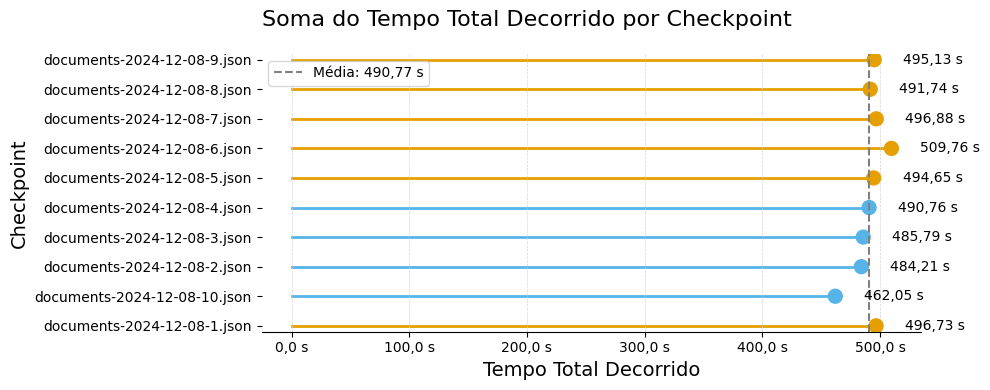

In [306]:
plot_horizontal_bar_chart(
    et_file,
    group_col="checkpoint",
    value_col="total_elapsed_time",
    title="Soma do Tempo Total Decorrido por Checkpoint",
    x_label="Tempo Total Decorrido",
    y_label="Checkpoint",
    big_numbers={"factor": 1, "suffix": "s"},
)

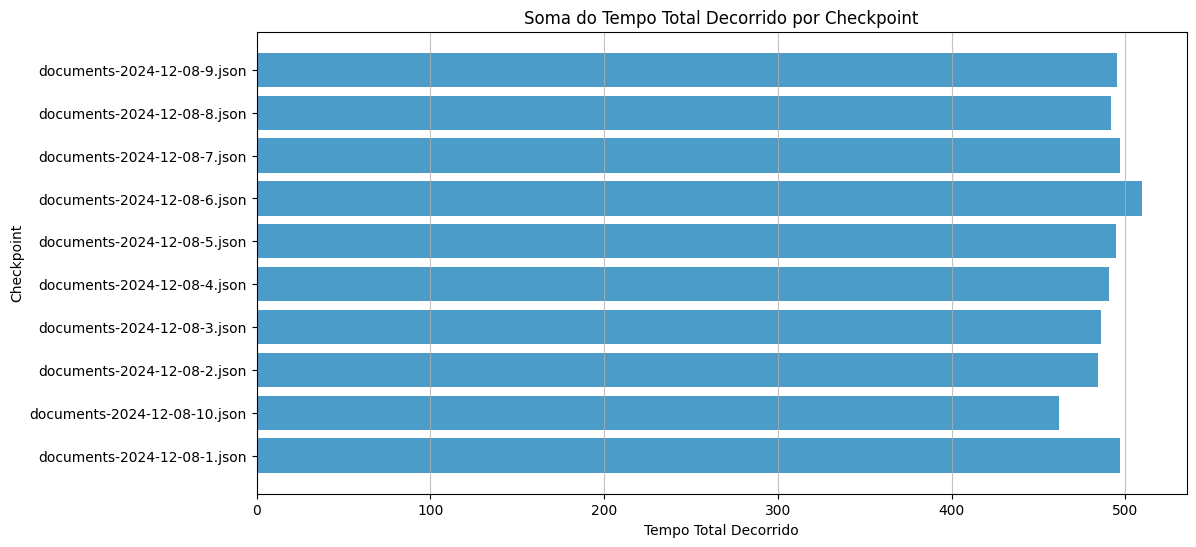

In [ ]:
# import matplotlib.pyplot as plt

# # Agrupando os dados por checkpoint e somando os tempos totais
# filtered = et_file.groupby("checkpoint")["total_elapsed_time"].sum().reset_index()

# # Criando o gráfico de barras para visualizar a soma do tempo total por checkpoint
# plt.figure(figsize=(12, 6))
# plt.barh(
#     filtered["checkpoint"], filtered["total_elapsed_time"], color="#0072B2", alpha=0.7
# )
# plt.title("Soma do Tempo Total Decorrido por Checkpoint")
# plt.xlabel("Tempo Total Decorrido")
# plt.ylabel("Checkpoint")
# plt.grid(axis="x", alpha=0.75)
# plt.show()

### Elapsed time by doc_type

In [280]:
query = """
SELECT id as doc_type, count(elapsed_times) as count_elapsed_time, sum(elapsed_times) as total_elapsed_time, avg(elapsed_times) as avg_elapsed_time
FROM RAW_ELAPSED_TIME
GROUP BY id
;
"""

et_doc_type = conn.sql(query).fetchdf()

et_doc_type

,doc_type,count_elapsed_time,total_elapsed_time,avg_elapsed_time
0,§ 275.0-2_P2,10,191.842291,19.184229
1,classify_P2_Definitional_terms,10,60.857267,6.085727
2,transform_Names,50,96.552598,1.931052
3,§ 275.0-7_P2,10,320.493807,32.049381
4,classify_P2_Definitional_names,10,63.713575,6.371357
5,validation_judge_Operative_Rules,60,171.995362,2.866589
6,validation_judge_Fact_Types,160,473.791661,2.961198
7,classify_P2_Operative_rules,10,48.054320,4.805432
8,§ 275.0-2_P1,10,315.096451,31.509645
9,classify_P1,10,216.614197,21.661420


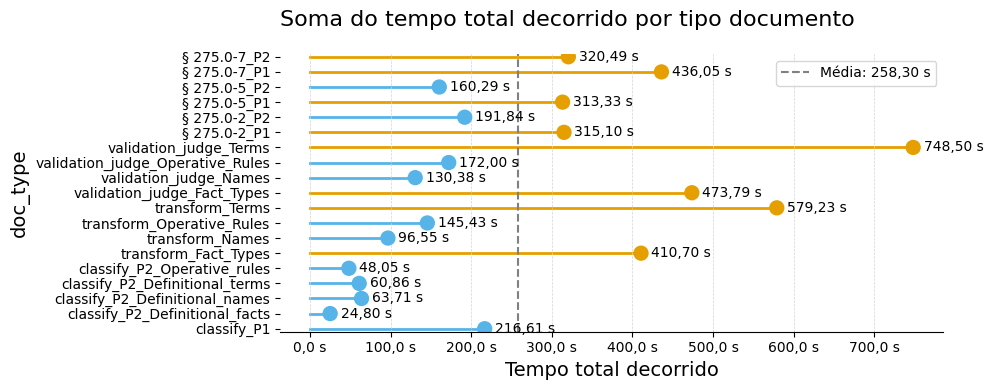

In [305]:
plot_horizontal_bar_chart(
    et_doc_type,
    group_col="doc_type",
    value_col="total_elapsed_time",
    title="Soma do tempo total decorrido por tipo documento",
    x_label="Tempo total decorrido",
    y_label="doc_type",
    big_numbers={"factor": 1, "suffix": "s"},
)

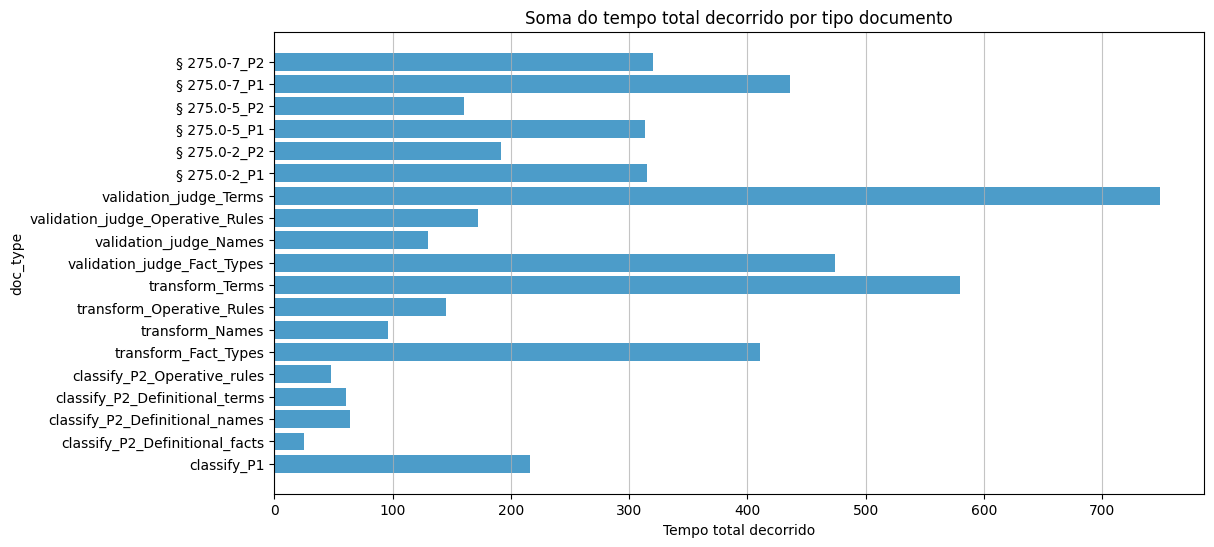

In [ ]:
# # Agrupando os dados por checkpoint e somando os tempos totais
# filtered = et_doc_type.groupby("doc_type")["total_elapsed_time"].sum().reset_index()

# # Criando o gráfico de barras para visualizar a soma do tempo total por checkpoint
# plt.figure(figsize=(12, 6))
# plt.barh(filtered["doc_type"], filtered["total_elapsed_time"], color="#0072B2", alpha=0.7)
# plt.title("Soma do tempo total decorrido por tipo documento")
# plt.xlabel("Tempo total decorrido")
# plt.ylabel("doc_type")
# plt.grid(axis="x", alpha=0.75)
# plt.show()

### Elapsed time by process

In [282]:
query = """
WITH CHECKPOINT AS (
    SELECT 
        PROCESS, 
        DOC_ID, 
        DOC_TYPE,
        DOC_SOURCE
    FROM 
        CHECKPOINT_METADATA
    GROUP BY 
        PROCESS, DOC_ID, DOC_TYPE, DOC_SOURCE
)
SELECT
    cm.process,
    cm.doc_id,
    cm.doc_type,
    cm.doc_source,
    COUNT(et.elapsed_times) AS count_elapsed_time,
    SUM(et.elapsed_times) AS total_elapsed_time,
    AVG(et.elapsed_times) AS avg_elapsed_time
FROM
    RAW_ELAPSED_TIME AS et
JOIN
    CHECKPOINT AS cm ON et.id = cm.doc_id
WHERE
    cm.doc_source in ('pred', 'val')
GROUP BY
    cm.process, cm.doc_id, cm.doc_type, cm.doc_source
ORDER BY
    cm.process, cm.doc_id, cm.doc_type, cm.doc_source;
"""

et_process = conn.sql(query).fetchdf()

et_process

,process,doc_id,doc_type,doc_source,count_elapsed_time,total_elapsed_time,avg_elapsed_time
0,classification,classify_P1,llm_response_classification,pred,10,216.614197,21.661420
1,classification,classify_P2_Definitional_facts,llm_response_classification,pred,10,24.796994,2.479699
2,classification,classify_P2_Definitional_names,llm_response_classification,pred,10,63.713575,6.371357
3,classification,classify_P2_Definitional_terms,llm_response_classification,pred,10,60.857267,6.085727
4,classification,classify_P2_Definitional_terms,true_table,pred,10,60.857267,6.085727
5,classification,classify_P2_Operative_rules,llm_response_classification,pred,10,48.054320,4.805432
6,extraction,§ 275.0-2_P1,llm_response,pred,10,315.096451,31.509645
7,extraction,§ 275.0-2_P2,llm_response,pred,10,191.842291,19.184229
8,extraction,§ 275.0-5_P1,llm_response,pred,10,313.327133,31.332713
9,extraction,§ 275.0-5_P2,llm_response,pred,10,160.286511,16.028651


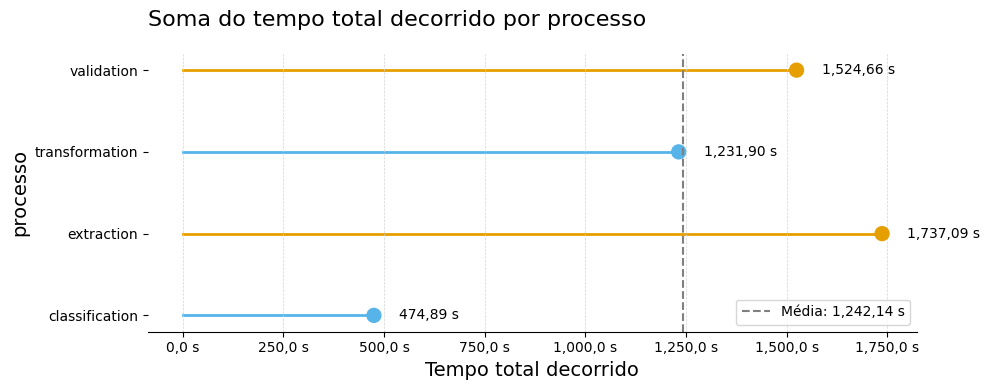

In [283]:
plot_horizontal_bar_chart(
    et_process,
    group_col="process",
    value_col="total_elapsed_time",
    title="Soma do tempo total decorrido por processo",
    x_label="Tempo total decorrido",
    y_label="processo",
    big_numbers={"factor": 1, "suffix": "s"},
)

In [320]:
et_process.groupby("process")["total_elapsed_time"].sum().reset_index()

,process,total_elapsed_time
0,classification,474.893620
1,extraction,1737.094956
2,transformation,1231.903466
3,validation,1524.663504


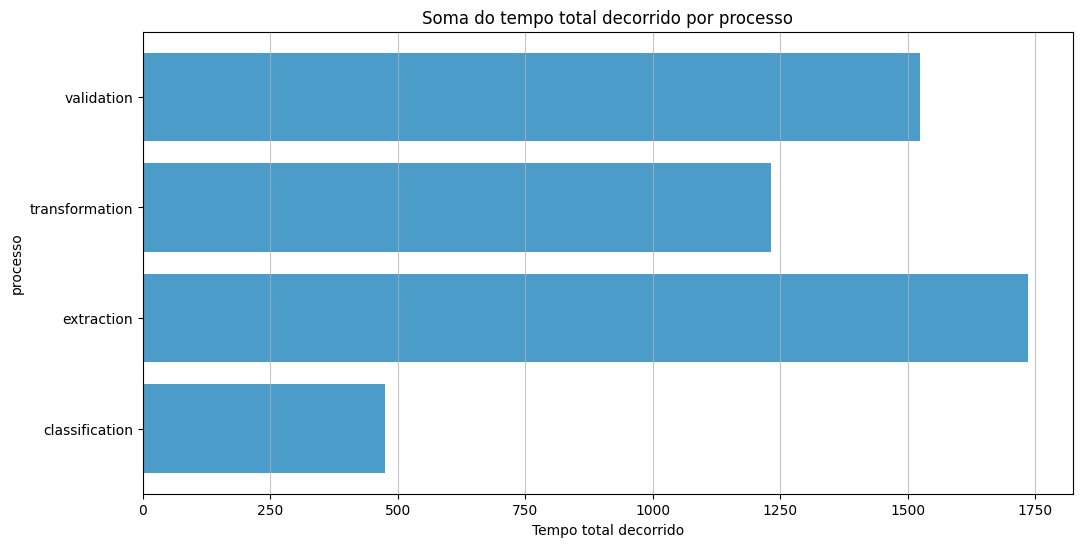

In [ ]:
# # Agrupando os dados por checkpoint e somando os tempos totais
# filtered = et_process.groupby("process")["total_elapsed_time"].sum().reset_index()

# # Criando o gráfico de barras para visualizar a soma do tempo total por checkpoint
# plt.figure(figsize=(12, 6))
# plt.barh(filtered["process"], filtered["total_elapsed_time"], color="#0072B2", alpha=0.7)
# plt.title("Soma do tempo total decorrido por processo")
# plt.xlabel("Tempo total decorrido")
# plt.ylabel("processo")
# plt.grid(axis="x", alpha=0.75)
# plt.show()

### Average elapsed time by process

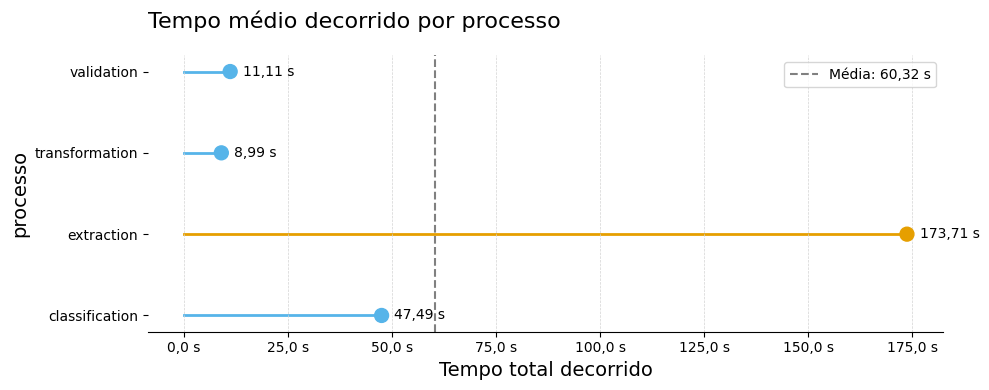

In [285]:
plot_horizontal_bar_chart(
    et_process,
    group_col="process",
    value_col="avg_elapsed_time",
    title="Tempo médio decorrido por processo",
    x_label="Tempo total decorrido",
    y_label="processo",
    big_numbers={"factor": 1, "suffix": "s"},
)

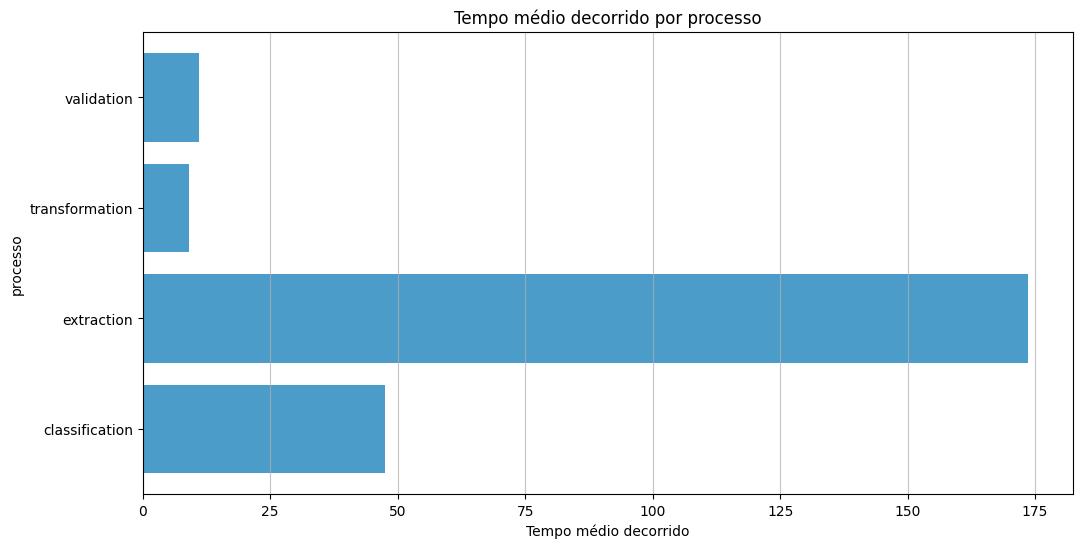

In [ ]:
# # Agrupando os dados por checkpoint e somando os tempos totais
# filtered = et_process.groupby("process")["avg_elapsed_time"].sum().reset_index()

# # Criando o gráfico de barras para visualizar a soma do tempo total por checkpoint
# plt.figure(figsize=(12, 6))
# plt.barh(filtered["process"], filtered["avg_elapsed_time"], color="#0072B2", alpha=0.7)
# plt.title("Tempo médio decorrido por processo")
# plt.xlabel("Tempo médio decorrido")
# plt.ylabel("processo")
# plt.grid(axis="x", alpha=0.75)
# plt.show()

### Elapsed time all runs

In [287]:
query = """
SELECT count(elapsed_times) as count_elapsed_time, sum(elapsed_times) as total_elapsed_time, avg(elapsed_times) as avg_elapsed_time
FROM RAW_ELAPSED_TIME
;
"""

elapsed_time_big_numbers = conn.sql(query).fetchdf()

conn.sql(query)

┌────────────────────┬────────────────────┬───────────────────┐
│ count_elapsed_time │ total_elapsed_time │ avg_elapsed_time  │
│       int64        │       double       │      double       │
├────────────────────┼────────────────────┼───────────────────┤
│               1210 │  4907.698278480075 │ 4.055948990479401 │
└────────────────────┴────────────────────┴───────────────────┘

In [288]:
print(f"count_elapsed_time: {humanize.intword(elapsed_time_big_numbers['count_elapsed_time'])}")
print(f"total_elapsed_time: {humanize.intword(elapsed_time_big_numbers['total_elapsed_time'])}")
print(f"avg_elapsed_time: {humanize.intword(elapsed_time_big_numbers['avg_elapsed_time'])}")

count_elapsed_time: 1.2 thousand
total_elapsed_time: 4.9 thousand
avg_elapsed_time: 4


/home/adsantos/miniconda3/envs/ipt-cfr2sbvr/lib/python3.11/site-packages/humanize/number.py:228: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  if not math.isfinite(float(value)):
/home/adsantos/miniconda3/envs/ipt-cfr2sbvr/lib/python3.11/site-packages/humanize/number.py:230: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  value = int(value)


## LLM completion

In [289]:
# Define the directory and pattern
directory = Path(f"{config['DEFAULT_DATA_DIR']}/checkpoints_evaluation")
pattern = "documents-*.json"

# Use glob to find all files matching the pattern
files = directory.glob(pattern)

drop = True  # Drop the table first time
for file_path in files:
    print(file_path)  # Output each file path
    upsert_table_from_json(
        conn,
        key_pattern1="|llm_",
        table_name="RAW_LLM_COMPLETION",
        source=file_path,
        key_value="llm_response",
        drop=drop,
        content_key="completions",
        alias="completions",
        doc_id_key="id",
    )
    drop = False  # Stop dropping tables

In [290]:
query = """
DESCRIBE RAW_LLM_COMPLETION
;
"""

conn.sql(query)

┌─────────────┬────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┬─────────┬─────────┬─────────┬─────────┐
│ column_name │                                                                                                                                                                                                                                                                  column_type                                                                                                                                   

In [291]:
query = """
SELECT 
    id, 
    file_source, 
    created_at, 
    completions.id,
    completions.model,
    completions.object,
    --completions.service_tier,
    completions.system_fingerprint,
    completions.usage.completion_tokens,
    completions.usage.prompt_tokens,
    completions.usage.total_tokens
    --completions.usage.completion_tokens_details,
    --completions.usage.prompt_tokens_details
FROM RAW_LLM_COMPLETION
;
"""

conn.sql(query).fetchdf()

,id,file_source,created_at,id_1,model,object,system_fingerprint,completion_tokens,prompt_tokens,total_tokens
0,§ 275.0-2_P1,documents-2024-12-08-1.json,2024-12-23 18:34:20.184000-03:00,chatcmpl-AZ5K0N2JMbQdLiwa8g9hwBkzMycAX,gpt-4o-2024-08-06,chat.completion,fp_7f6be3efb0,3325,2260,5585
1,§ 275.0-2_P2,documents-2024-12-08-1.json,2024-12-23 18:34:20.184000-03:00,chatcmpl-AZ5KYA9BySITa29a3PmiGK3N4GWIh,gpt-4o-2024-08-06,chat.completion,fp_831e067d82,1764,1593,3357
2,§ 275.0-5_P1,documents-2024-12-08-1.json,2024-12-23 18:34:20.184000-03:00,chatcmpl-AZ5KusMsHAppI2aejKut4wUWk4ZZ8,gpt-4o-2024-08-06,chat.completion,fp_7f6be3efb0,2511,2086,4597
3,§ 275.0-5_P2,documents-2024-12-08-1.json,2024-12-23 18:34:20.184000-03:00,chatcmpl-AZ5LTi6wLXmNqpwMHBe6sdKRYuhef,gpt-4o-2024-08-06,chat.completion,fp_831e067d82,1345,1389,2734
4,§ 275.0-7_P1,documents-2024-12-08-1.json,2024-12-23 18:34:20.184000-03:00,chatcmpl-AZ5LlFIxbhlWJuIyI81nrAFJ3AaPZ,gpt-4o-2024-08-06,chat.completion,fp_7f6be3efb0,4517,2421,6938
...,...,...,...,...,...,...,...,...,...,...
1205,validation_judge_Names,documents-2024-12-08-9.json,2024-12-23 18:34:20.956000-03:00,chatcmpl-AeZqGRVxUxTo1X1LSCj3gtphDjHgG,gpt-4o-2024-08-06,chat.completion,fp_9faba9f038,186,4630,4816
1206,validation_judge_Names,documents-2024-12-08-9.json,2024-12-23 18:34:20.956000-03:00,chatcmpl-AeZqMsjeamRmkwvmLDY402OpnpssI,gpt-4o-2024-08-06,chat.completion,fp_9faba9f038,166,4626,4792
1207,validation_judge_Names,documents-2024-12-08-9.json,2024-12-23 18:34:20.956000-03:00,chatcmpl-AeZqRsHxzPJNNWHuWHRxhqdDfCDcC,gpt-4o-2024-08-06,chat.completion,fp_9faba9f038,174,4595,4769
1208,validation_judge_Names,documents-2024-12-08-9.json,2024-12-23 18:34:20.956000-03:00,chatcmpl-AeZqWZ66NNdHJGsRqsezAQ5lg3oP8,gpt-4o-2024-08-06,chat.completion,fp_9faba9f038,167,4602,4769


In [292]:
query = """
WITH CHECKPOINT AS (
    SELECT 
        PROCESS, 
        DOC_ID, 
        DOC_TYPE,
        DOC_SOURCE
    FROM 
        CHECKPOINT_METADATA
    GROUP BY 
        PROCESS, DOC_ID, DOC_TYPE, DOC_SOURCE
)
SELECT 
    id as doc_id,
    cm.process,
    cm.doc_source as doc_source,
    file_source as checkpoint, 
    created_at, 
    completions.id as completion_id,
    completions.model,
    completions.object,
    --completions.service_tier,
    completions.system_fingerprint,
    completions.usage.completion_tokens,
    completions.usage.prompt_tokens,
    completions.usage.total_tokens
    --completions.usage.completion_tokens_details,
    --completions.usage.prompt_tokens_details
FROM RAW_LLM_COMPLETION AS lc
JOIN
    CHECKPOINT AS cm ON lc.id = cm.doc_id
WHERE
    cm.doc_source in ('pred', 'val')
--GROUP BY
--    cm.process, cm.doc_id, cm.doc_type, cm.doc_source
--ORDER BY
--    cm.process, cm.doc_id, cm.doc_type, cm.doc_source;
"""

lc_process = conn.sql(query).fetchdf()

lc_process

,doc_id,process,doc_source,checkpoint,created_at,completion_id,model,object,system_fingerprint,completion_tokens,prompt_tokens,total_tokens
0,§ 275.0-2_P1,extraction,pred,documents-2024-12-08-1.json,2024-12-23 18:34:20.184000-03:00,chatcmpl-AZ5K0N2JMbQdLiwa8g9hwBkzMycAX,gpt-4o-2024-08-06,chat.completion,fp_7f6be3efb0,3325,2260,5585
1,§ 275.0-2_P2,extraction,pred,documents-2024-12-08-1.json,2024-12-23 18:34:20.184000-03:00,chatcmpl-AZ5KYA9BySITa29a3PmiGK3N4GWIh,gpt-4o-2024-08-06,chat.completion,fp_831e067d82,1764,1593,3357
2,§ 275.0-5_P1,extraction,pred,documents-2024-12-08-1.json,2024-12-23 18:34:20.184000-03:00,chatcmpl-AZ5KusMsHAppI2aejKut4wUWk4ZZ8,gpt-4o-2024-08-06,chat.completion,fp_7f6be3efb0,2511,2086,4597
3,§ 275.0-5_P2,extraction,pred,documents-2024-12-08-1.json,2024-12-23 18:34:20.184000-03:00,chatcmpl-AZ5LTi6wLXmNqpwMHBe6sdKRYuhef,gpt-4o-2024-08-06,chat.completion,fp_831e067d82,1345,1389,2734
4,§ 275.0-7_P1,extraction,pred,documents-2024-12-08-1.json,2024-12-23 18:34:20.184000-03:00,chatcmpl-AZ5LlFIxbhlWJuIyI81nrAFJ3AaPZ,gpt-4o-2024-08-06,chat.completion,fp_7f6be3efb0,4517,2421,6938
...,...,...,...,...,...,...,...,...,...,...,...,...
1215,classify_P2_Definitional_terms,classification,pred,documents-2024-12-08-5.json,2024-12-23 18:34:20.614000-03:00,chatcmpl-AcFhRW2uTBnnsnNW0HioWjPzY2TCI,gpt-4o-2024-08-06,chat.completion,fp_9d50cd990b,531,7867,8398
1216,classify_P2_Definitional_terms,classification,pred,documents-2024-12-08-6.json,2024-12-23 18:34:20.695000-03:00,chatcmpl-AcFhRW2uTBnnsnNW0HioWjPzY2TCI,gpt-4o-2024-08-06,chat.completion,fp_9d50cd990b,531,7867,8398
1217,classify_P2_Definitional_terms,classification,pred,documents-2024-12-08-7.json,2024-12-23 18:34:20.780000-03:00,chatcmpl-AcFhRW2uTBnnsnNW0HioWjPzY2TCI,gpt-4o-2024-08-06,chat.completion,fp_9d50cd990b,531,7867,8398
1218,classify_P2_Definitional_terms,classification,pred,documents-2024-12-08-8.json,2024-12-23 18:34:20.866000-03:00,chatcmpl-AcFhRW2uTBnnsnNW0HioWjPzY2TCI,gpt-4o-2024-08-06,chat.completion,fp_9d50cd990b,531,7867,8398


### Tokens per process

In [293]:
query = """
WITH CHECKPOINT AS (
    SELECT 
        PROCESS, 
        DOC_ID, 
        DOC_TYPE,
        DOC_SOURCE
    FROM 
        CHECKPOINT_METADATA
    GROUP BY 
        PROCESS, DOC_ID, DOC_TYPE, DOC_SOURCE
)
SELECT 
    cm.process,
    cm.doc_id,
    cm.doc_type,
    cm.doc_source,
    lc.file_source as checkpoint,
    COUNT(lc.id) AS count_completions,
    SUM(lc.completions.usage.completion_tokens) AS total_completion_tokens,
    AVG(lc.completions.usage.completion_tokens) AS avg_completion_tokens,

    SUM(lc.completions.usage.prompt_tokens) AS total_prompt_tokens,
    AVG(lc.completions.usage.prompt_tokens) AS avg_prompt_tokens,

    SUM(lc.completions.usage.total_tokens) AS total_total_tokens,
    AVG(lc.completions.usage.total_tokens) AS avg_total_tokens,
    
    MAX(lc.created_at) AS last_completion
FROM RAW_LLM_COMPLETION AS lc
JOIN
    CHECKPOINT AS cm ON lc.id = cm.doc_id
WHERE
    cm.doc_source in ('pred', 'val')
GROUP BY
    cm.process, cm.doc_id, cm.doc_type, cm.doc_source, lc.file_source
ORDER BY
    cm.process, cm.doc_id, cm.doc_type, cm.doc_source, lc.file_source;
"""

et_llm_completion = conn.sql(query).fetchdf()

et_llm_completion

,process,doc_id,doc_type,doc_source,checkpoint,count_completions,total_completion_tokens,avg_completion_tokens,total_prompt_tokens,avg_prompt_tokens,total_total_tokens,avg_total_tokens,last_completion
0,classification,classify_P1,llm_response_classification,pred,documents-2024-12-08-1.json,1,1294.0,1294.000000,2499.0,2499.000000,3793.0,3793.000000,2024-12-23 18:34:20.184000-03:00
1,classification,classify_P1,llm_response_classification,pred,documents-2024-12-08-10.json,1,1294.0,1294.000000,2499.0,2499.000000,3793.0,3793.000000,2024-12-23 18:34:20.275000-03:00
2,classification,classify_P1,llm_response_classification,pred,documents-2024-12-08-2.json,1,1294.0,1294.000000,2499.0,2499.000000,3793.0,3793.000000,2024-12-23 18:34:20.360000-03:00
3,classification,classify_P1,llm_response_classification,pred,documents-2024-12-08-3.json,1,1294.0,1294.000000,2499.0,2499.000000,3793.0,3793.000000,2024-12-23 18:34:20.445000-03:00
4,classification,classify_P1,llm_response_classification,pred,documents-2024-12-08-4.json,1,1294.0,1294.000000,2499.0,2499.000000,3793.0,3793.000000,2024-12-23 18:34:20.530000-03:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,validation,validation_judge_Terms,llm_validation,val,documents-2024-12-08-5.json,28,4652.0,166.142857,113079.0,4038.535714,117731.0,4204.678571,2024-12-23 18:34:20.614000-03:00
196,validation,validation_judge_Terms,llm_validation,val,documents-2024-12-08-6.json,28,4657.0,166.321429,113090.0,4038.928571,117747.0,4205.250000,2024-12-23 18:34:20.695000-03:00
197,validation,validation_judge_Terms,llm_validation,val,documents-2024-12-08-7.json,28,4640.0,165.714286,113071.0,4038.250000,117711.0,4203.964286,2024-12-23 18:34:20.780000-03:00
198,validation,validation_judge_Terms,llm_validation,val,documents-2024-12-08-8.json,28,4638.0,165.642857,113078.0,4038.500000,117716.0,4204.142857,2024-12-23 18:34:20.866000-03:00


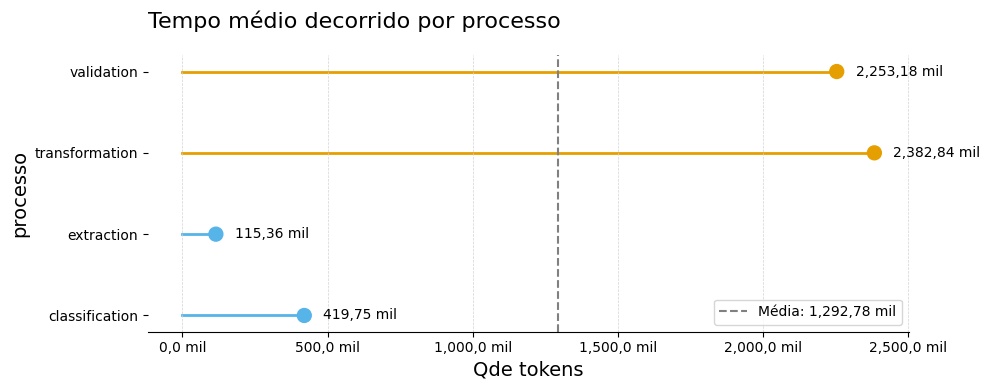

In [310]:
plot_horizontal_bar_chart(
    et_llm_completion,
    group_col="process",
    value_col="total_prompt_tokens",
    title="Tempo médio decorrido por processo",
    x_label="Qde tokens",
    y_label="processo"
)

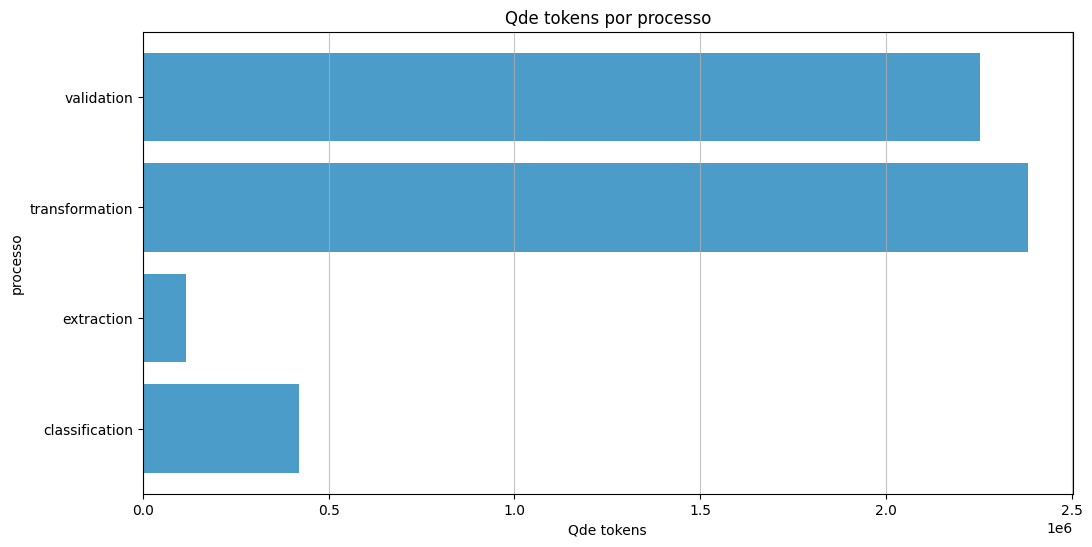

In [ ]:
# # Agrupando os dados por checkpoint e somando os tempos totais
# filterd = et_llm_completion.groupby("process")["total_prompt_tokens"].sum().reset_index()

# # Criando o gráfico de barras para visualizar a soma do tempo total por checkpoint
# plt.figure(figsize=(12, 6))
# plt.barh(filterd["process"], filterd["total_prompt_tokens"], color="#0072B2", alpha=0.7)
# plt.title("Qde tokens por processo")
# plt.xlabel("Qde tokens")
# plt.ylabel("processo")
# plt.grid(axis="x", alpha=0.75)
# plt.show()

### Avarege tokens per process

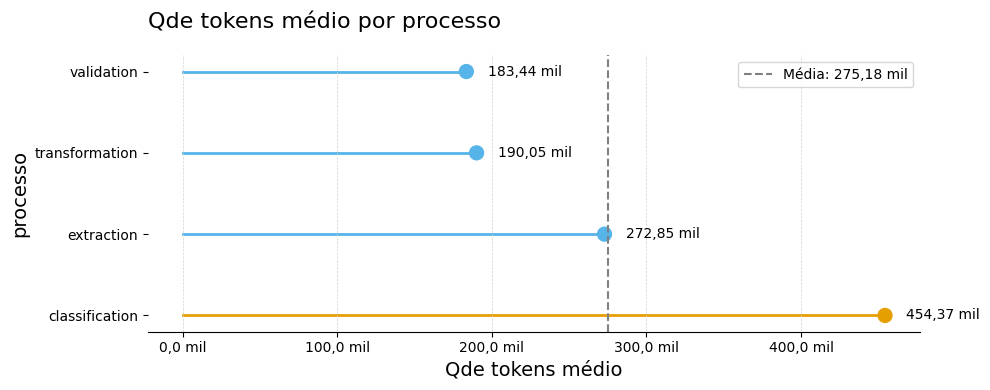

In [309]:
plot_horizontal_bar_chart(
    et_llm_completion,
    group_col="process",
    value_col="avg_total_tokens",
    title="Qde tokens médio por processo",
    x_label="Qde tokens médio",
    y_label="processo"
)

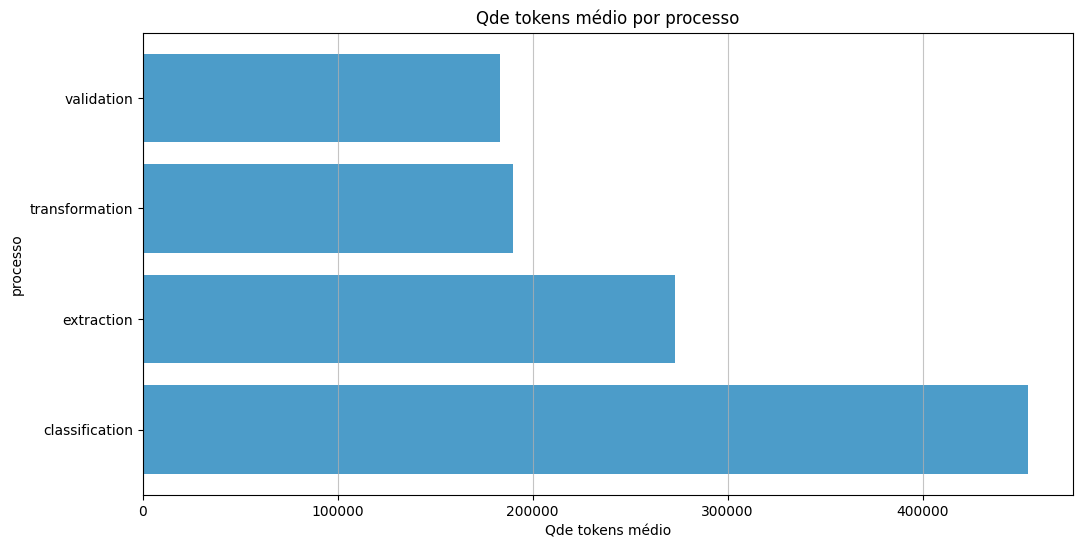

In [ ]:
# # Agrupando os dados por checkpoint e somando os tempos totais
# filterd = et_llm_completion.groupby("process")["avg_total_tokens"].sum().reset_index()

# # Criando o gráfico de barras para visualizar a soma do tempo total por checkpoint
# plt.figure(figsize=(12, 6))
# plt.barh(filterd["process"], filterd["avg_total_tokens"], color="#0072B2", alpha=0.7)
# plt.title("Qde tokens médio por processo")
# plt.xlabel("Qde tokens médio")
# plt.ylabel("processo")
# plt.grid(axis="x", alpha=0.75)
# plt.show()

### Tokens per document type

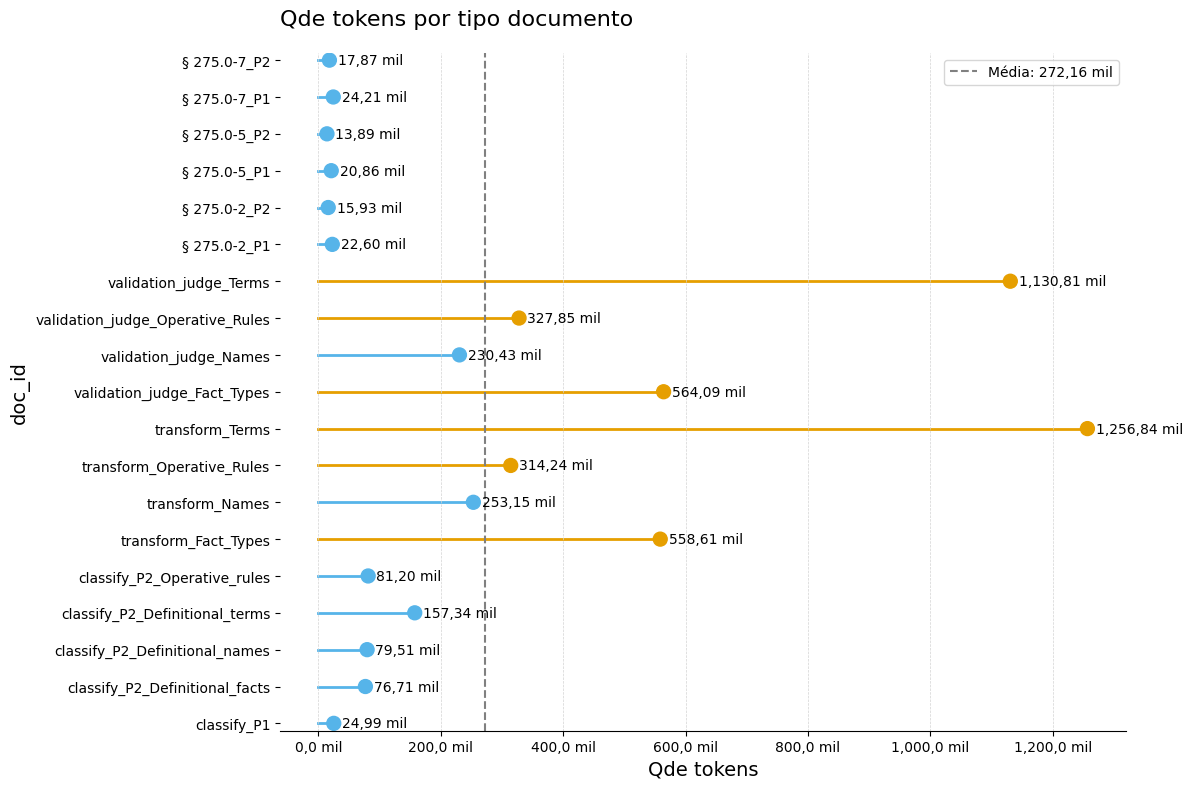

In [314]:
plot_horizontal_bar_chart(
    et_llm_completion,
    group_col="doc_id",
    value_col="total_prompt_tokens",
    title="Qde tokens por tipo documento",
    x_label="Qde tokens",
    y_label="doc_id",
    figsize=(12, 8)
)

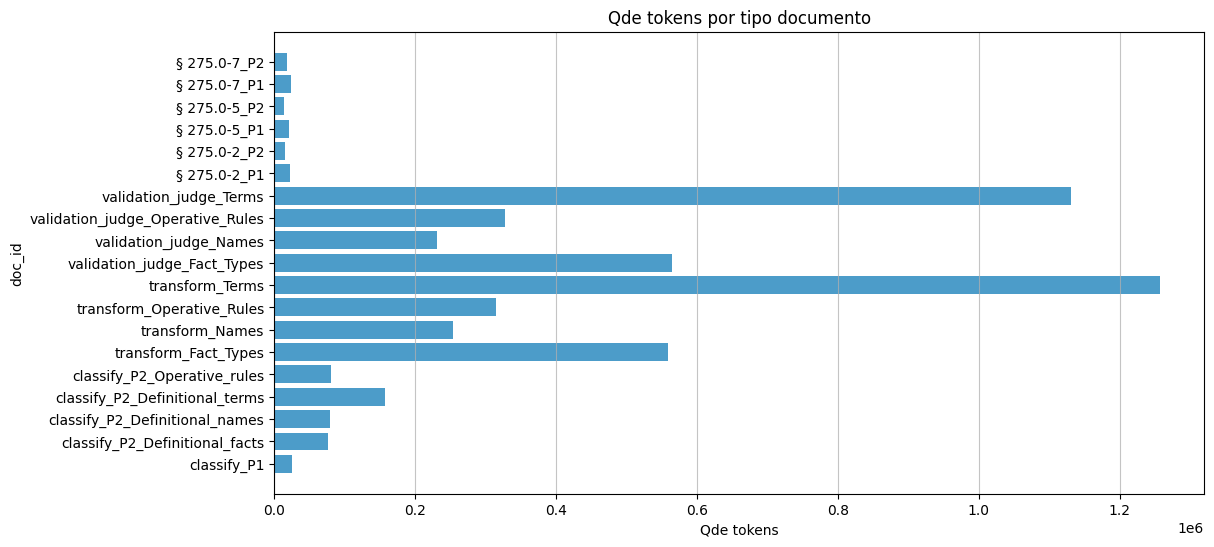

In [ ]:
# # Agrupando os dados por checkpoint e somando os tempos totais
# filterd = et_llm_completion.groupby("doc_id")["total_prompt_tokens"].sum().reset_index()

# # Criando o gráfico de barras para visualizar a soma do tempo total por checkpoint
# plt.figure(figsize=(12, 6))
# plt.barh(filterd["doc_id"], filterd["total_prompt_tokens"], color="#0072B2", alpha=0.7)
# plt.title("Qde tokens por tipo documento")
# plt.xlabel("Qde tokens")
# plt.ylabel("doc_id")
# plt.grid(axis="x", alpha=0.75)
# plt.show()

### Average tokens per checkpoint

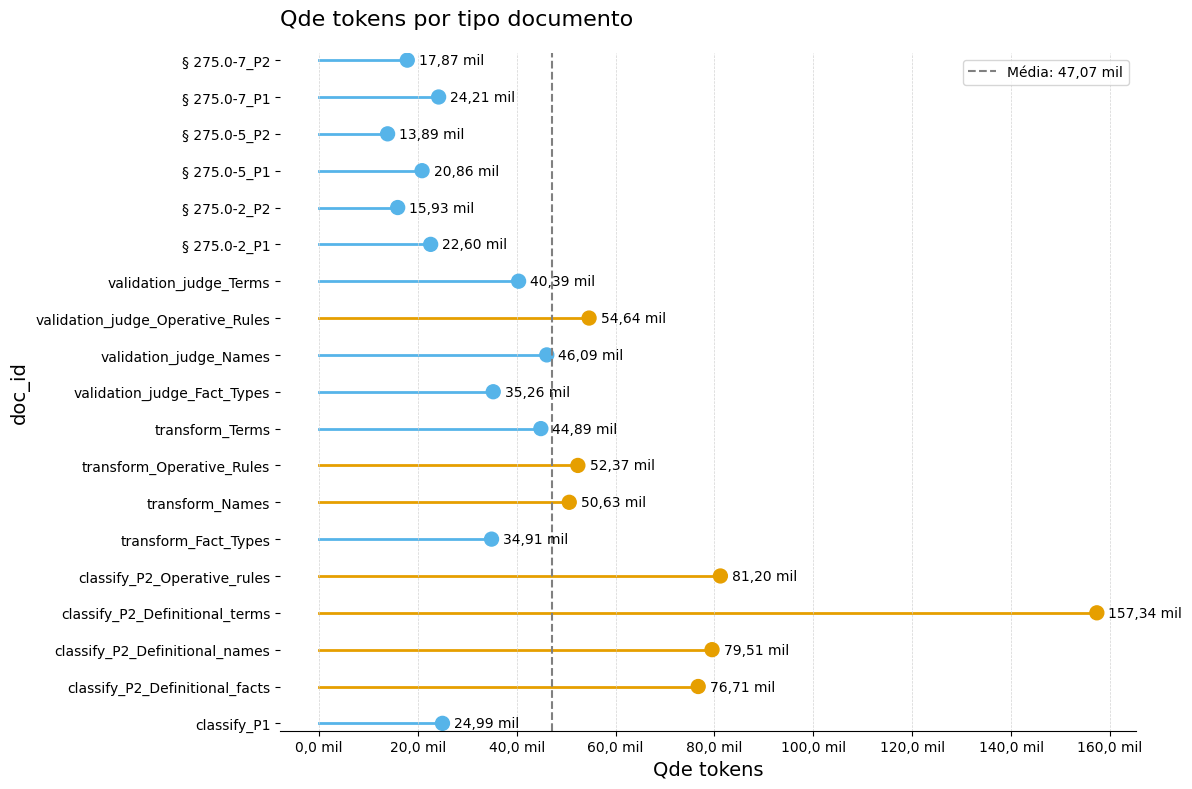

In [315]:
plot_horizontal_bar_chart(
    et_llm_completion,
    group_col="doc_id",
    value_col="avg_prompt_tokens",
    title="Qde tokens por tipo documento",
    x_label="Qde tokens",
    y_label="doc_id",
    figsize=(12, 8)
)

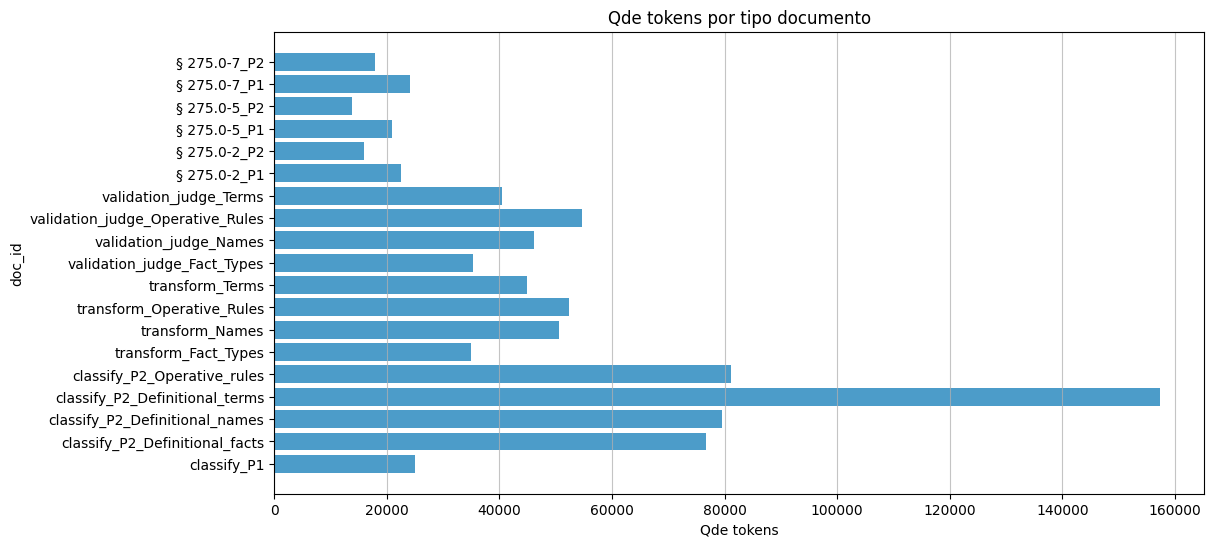

In [297]:
# # Agrupando os dados por checkpoint e somando os tempos totais
# filterd = et_llm_completion.groupby("doc_id")["avg_prompt_tokens"].sum().reset_index()

# # Criando o gráfico de barras para visualizar a soma do tempo total por checkpoint
# plt.figure(figsize=(12, 6))
# plt.barh(filterd["doc_id"], filterd["avg_prompt_tokens"], color="#0072B2", alpha=0.7)
# plt.title("Qde tokens por tipo documento")
# plt.xlabel("Qde tokens")
# plt.ylabel("doc_id")
# plt.grid(axis="x", alpha=0.75)
# plt.show()

### Tokens per checkpoint

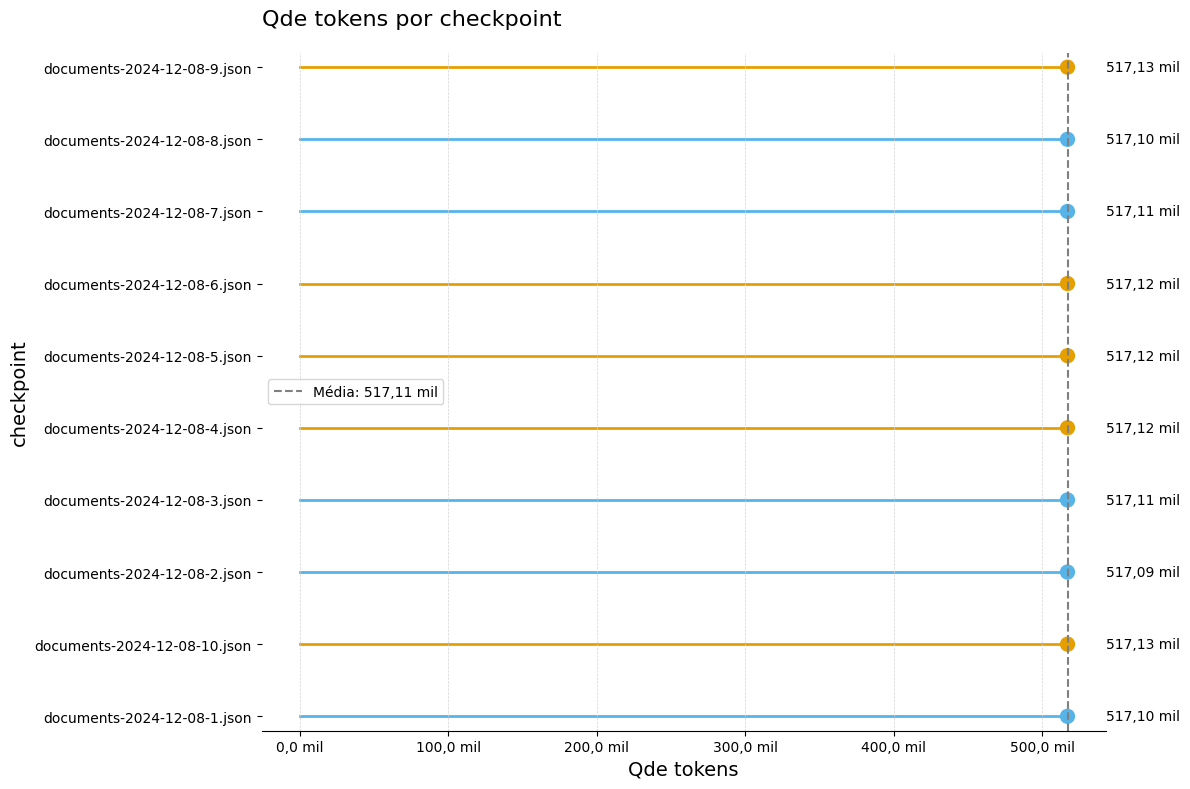

In [316]:
plot_horizontal_bar_chart(
    et_llm_completion,
    group_col="checkpoint",
    value_col="total_prompt_tokens",
    title="Qde tokens por checkpoint",
    x_label="Qde tokens",
    y_label="checkpoint",
    figsize=(12, 8)
)

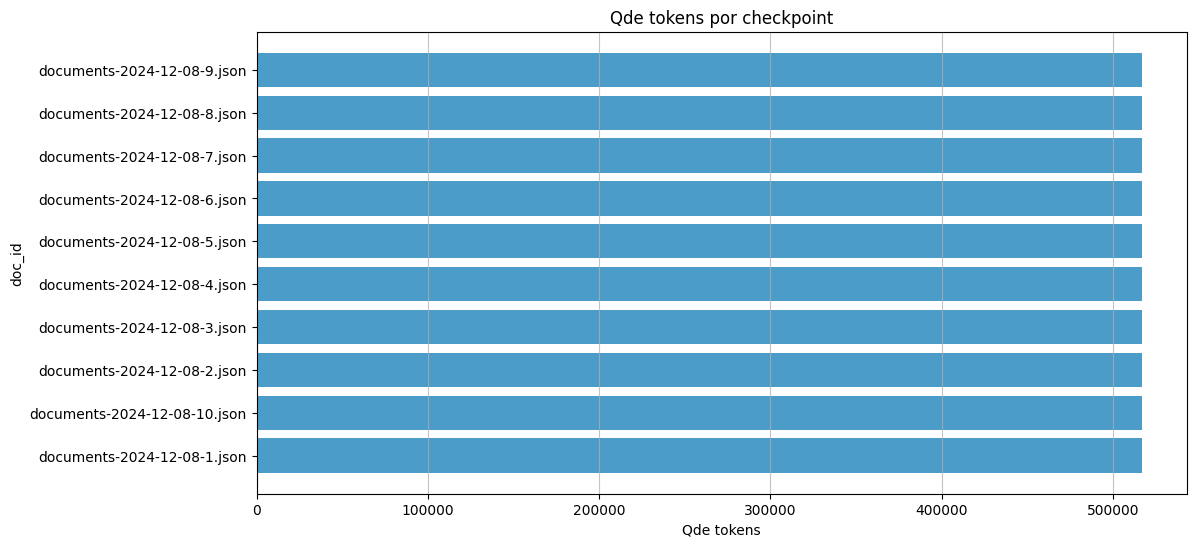

In [ ]:
# # Agrupando os dados por checkpoint e somando os tempos totais
# filterd = et_llm_completion.groupby("checkpoint")["total_prompt_tokens"].sum().reset_index()

# # Criando o gráfico de barras para visualizar a soma do tempo total por checkpoint
# plt.figure(figsize=(12, 6))
# plt.barh(filterd["checkpoint"], filterd["total_prompt_tokens"], color="#0072B2", alpha=0.7)
# plt.title("Qde tokens por checkpoint")
# plt.xlabel("Qde tokens")
# plt.ylabel("checkpoint")
# plt.grid(axis="x", alpha=0.75)
# plt.show()

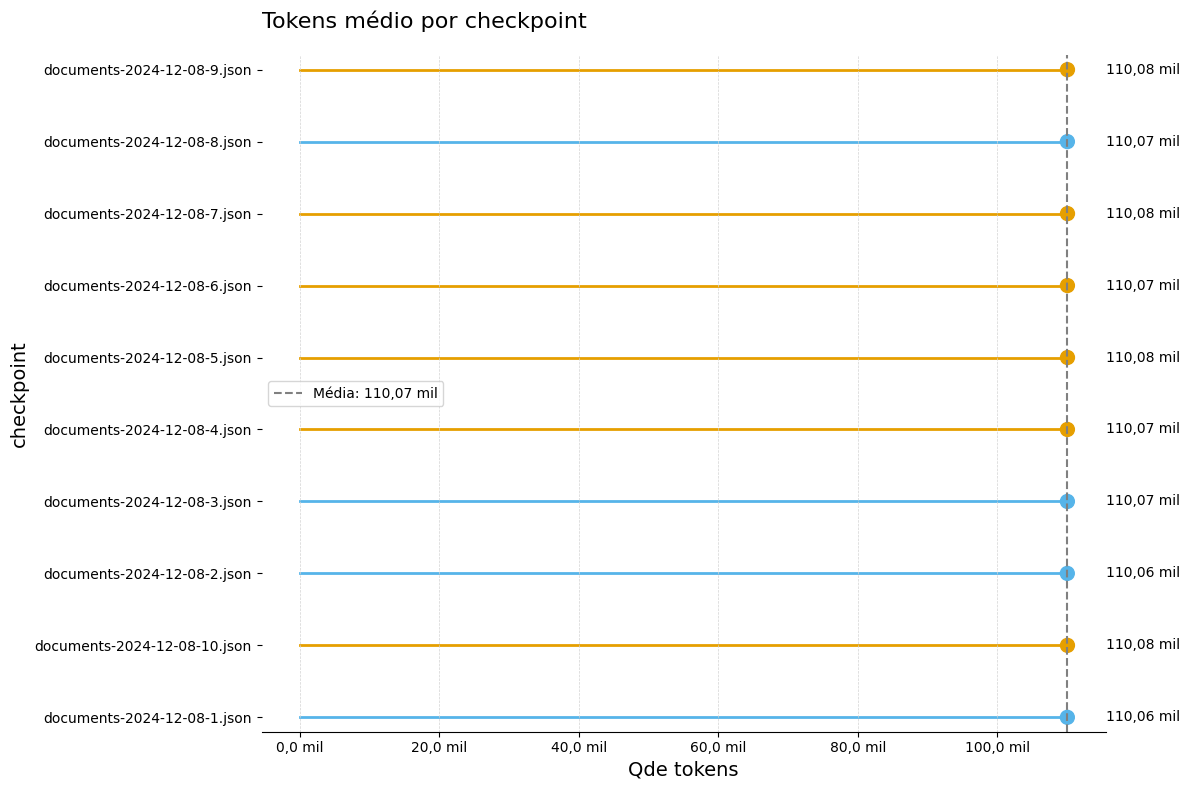

In [317]:
plot_horizontal_bar_chart(
    et_llm_completion,
    group_col="checkpoint",
    value_col="avg_total_tokens",
    title="Tokens médio por checkpoint",
    x_label="Qde tokens",
    y_label="checkpoint",
    figsize=(12, 8)
)

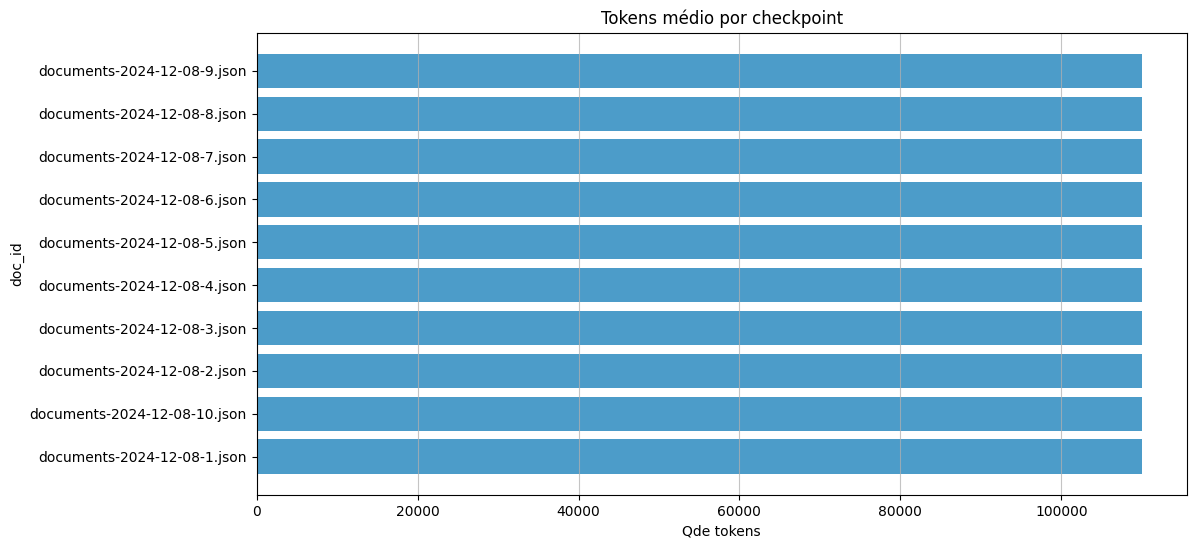

In [ ]:
# # Agrupando os dados por checkpoint e somando os tempos totais
# filterd = et_llm_completion.groupby("checkpoint")["avg_total_tokens"].sum().reset_index()

# # Criando o gráfico de barras para visualizar a soma do tempo total por checkpoint
# plt.figure(figsize=(12, 6))
# plt.barh(filterd["checkpoint"], filterd["avg_total_tokens"], color="#0072B2", alpha=0.7)
# plt.title("Tokens médio por checkpoint")
# plt.xlabel("Qde tokens")
# plt.ylabel("checkpoint")
# plt.grid(axis="x", alpha=0.75)
# plt.show()

### Tokens total

In [319]:
query = """
WITH CHECKPOINT AS (
    SELECT 
        PROCESS, 
        DOC_ID, 
        DOC_TYPE,
        DOC_SOURCE
    FROM 
        CHECKPOINT_METADATA
    GROUP BY 
        PROCESS, DOC_ID, DOC_TYPE, DOC_SOURCE
)
SELECT
    cm.process,
    COUNT(lc.id) AS count_completions,
    SUM(lc.completions.usage.completion_tokens) AS total_completion_tokens,
    AVG(lc.completions.usage.completion_tokens) AS avg_completion_tokens,

    SUM(lc.completions.usage.prompt_tokens) AS total_prompt_tokens,
    AVG(lc.completions.usage.prompt_tokens) AS avg_prompt_tokens,

    SUM(lc.completions.usage.total_tokens) AS total_total_tokens,
    AVG(lc.completions.usage.total_tokens) AS avg_total_tokens,
    
    MAX(lc.created_at) AS last_completion
FROM RAW_LLM_COMPLETION AS lc
JOIN
    CHECKPOINT AS cm ON lc.id = cm.doc_id
WHERE
    cm.doc_source in ('pred', 'val')
GROUP BY
    cm.process
"""

token_big_numbers = conn.sql(query).fetchdf()

conn.sql(query)

┌────────────────┬───────────────────┬─────────────────────────┬───────────────────────┬─────────────────────┬────────────────────┬────────────────────┬───────────────────┬────────────────────────────┐
│    process     │ count_completions │ total_completion_tokens │ avg_completion_tokens │ total_prompt_tokens │ avg_prompt_tokens  │ total_total_tokens │ avg_total_tokens  │      last_completion       │
│    varchar     │       int64       │         int128          │        double         │       int128        │       double       │       int128       │      double       │  timestamp with time zone  │
├────────────────┼───────────────────┼─────────────────────────┼───────────────────────┼─────────────────────┼────────────────────┼────────────────────┼───────────────────┼────────────────────────────┤
│ transformation │               550 │                   97500 │    177.27272727272728 │             2382840 │  4332.436363636363 │            2480340 │ 4509.709090909091 │ 2024-12-23 18:34:20

In [301]:
print(f"total_prompt_tokens: {humanize.intword(token_big_numbers['total_prompt_tokens'])}")
print(f"total_completion_tokens: {humanize.intword(token_big_numbers['total_completion_tokens'])}")
print(f"total_total_tokens: {humanize.intword(token_big_numbers['total_total_tokens'])}")

total_prompt_tokens: 5.2 million
total_completion_tokens: 385.5 thousand
total_total_tokens: 5.6 million


/home/adsantos/miniconda3/envs/ipt-cfr2sbvr/lib/python3.11/site-packages/humanize/number.py:228: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  if not math.isfinite(float(value)):
/home/adsantos/miniconda3/envs/ipt-cfr2sbvr/lib/python3.11/site-packages/humanize/number.py:230: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  value = int(value)


## Close conn

In [48]:
conn.close()

## Discussão

### Cores Acessíveis para Daltonismo

1. **Paletas de Cores**: Use paletas que foram projetadas especificamente para serem amigáveis ao daltonismo. Algumas paletas populares incluem:
   - **Color Universal Design (CUD)**: Uma paleta que utiliza cores que são facilmente distinguíveis por pessoas com diferentes tipos de daltonismo.
   - **Viridis**: Uma paleta de cores que varia de amarelo a verde escuro, que é perceptível para a maioria das pessoas.
   - **Cividis**: Uma paleta que varia de azul a amarelo, adequada para pessoas com daltonismo.

2. **Cores Sugeridas**:
   - **Azul**: (#0072B2) - Um azul claro é geralmente bem percebido.
   - **Laranja**: (#D95F02) - Um laranja forte é facilmente distinguível.
   - **Verde**: (#009E73) - Um verde mais escuro é uma boa escolha.
   - **Cinza**: (#999999) - O cinza é uma cor neutra que pode ser usada para contrastar com cores mais vibrantes.
